In [1]:
# pip install statsmodels

In [2]:
import pandas as pd
import numpy as np
import os
import re
from datetime import datetime
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib.patches as mpatches
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

In this notebook, we will be addressing subgroup B question 1.

1. How can we accurately predict guest flow and demand for various attractions and services? 

- Develop a demand forecasting model using historical data, guest journey patterns, and external factors (e.g., weather, events).
- Identify key factors influencing demand fluctuations.

We will be predicting the guest flow and demand for attractions, shops and food stores.

# Read files

In [126]:
survey_data = pd.read_csv("../data/final_synthetic_data.csv") # real and synthetic survey data
daily_avg_wait_time_df = pd.read_csv("../data/daily_avg_wait_time_df.csv") # daily average wait time from 2019 to 2024 (real is only 2023-2024)
combined_wait_time_df = pd.read_csv("../data/combined_wait_time_df.csv") # 5-minute interval wait time from 2019 to 2024 (real is only 2023-2024)

last_date = combined_wait_time_df['date'].max()
print(f"Last date in combined_wait_time_df: {last_date}")

weather_df = pd.read_csv("../data/weather_df.csv")
weather_df['date'] = pd.to_datetime(weather_df['date'])

# old weather data
# combine the weather data into one df
# folder_path = "../data/weather_data"
# csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]
# dfs = []
# for file in csv_files:
#     # Extract the year from the filename
#     year = file.split('_')[-1].split('.')[0]
    
#     # Read only the specified columns
#     df = pd.read_csv(os.path.join(folder_path, file), usecols=["date", "precipitation (GPM)"])

#     # add year to "date" column
#     df["date"] = pd.to_datetime(df["date"] + f'-{year}')

#     # rename "precipitation (GPM)" column to "precipitation"
#     df = df.rename(columns={"precipitation (GPM)": "precipitation"})

#     # Append the DataFrame to the list
#     dfs.append(df)

# weather_df = pd.concat(dfs, ignore_index=True)



Last date in combined_wait_time_df: 2024-10-21


In [127]:
print(f"No. of null values in weather df: {weather_df.isna().sum()}")
print(f"Earliest date in weather df: {weather_df['date'].min()}")
print(f"Last date in weather df: {weather_df['date'].max()}")

No. of null values in weather df: date             0
precipitation    0
dtype: int64
Earliest date in weather df: 2023-01-01 00:00:00
Last date in weather df: 2024-10-31 00:00:00


## Public/school holiday and HHN dates

Two separate dictionaries are created containing the dates of public and school holidays and HHN dates.

The following functions are created:
1. is_public_or_school_holiday: check if a given date is a public or school holiday
2. is_hhn: check if a given date is a halloween horror night day

In [202]:
# Define the dictionary with public and school holidays from 2019 to 2024
public_and_school_holidays = {
    2019: {
        "New Year's Day": "1 Jan 2019",
        "Chinese New Year": ["5 Feb 2019", "6 Feb 2019"],
        "March School Holidays": ["16 Mar 2019", "17 Mar 2019", "18 Mar 2019", "19 Mar 2019", "20 Mar 2019", "21 Mar 2019", "22 Mar 2019", "23 Mar 2019", "24 Mar 2019"],
        "Good Friday": "19 Apr 2019",
        "Labour Day": "1 May 2019",
        "Vesak Day": "19 May 2019",
        "June School Holidays": ["1 Jun 2019", "2 Jun 2019", "3 Jun 2019", "4 Jun 2019", "5 Jun 2019", "6 Jun 2019", "7 Jun 2019", "8 Jun 2019", "9 Jun 2019", "10 Jun 2019", "11 Jun 2019", "12 Jun 2019", "13 Jun 2019", "14 Jun 2019", "15 Jun 2019", "16 Jun 2019", "17 Jun 2019", "18 Jun 2019", "19 Jun 2019", "20 Jun 2019", "21 Jun 2019", "22 Jun 2019", "23 Jun 2019", "24 Jun 2019", "25 Jun 2019", "26 Jun 2019", "27 Jun 2019", "28 Jun 2019", "29 Jun 2019", "30 Jun 2019"],
        "Hari Raya Puasa": "5 Jun 2019",
        "National Day": "9 Aug 2019",
        "Hari Raya Haji": "11 Aug 2019",
        "September School Holidays": ["7 Sep 2019", "8 Sep 2019", "9 Sep 2019", "10 Sep 2019", "11 Sep 2019", "12 Sep 2019", "13 Sep 2019", "14 Sep 2019"],
        "Deepavali": "27 Oct 2019",
        "December School Holidays": ["16 Nov 2019", "17 Nov 2019", "18 Nov 2019", "19 Nov 2019", "20 Nov 2019", "21 Nov 2019", "22 Nov 2019", "23 Nov 2019", "24 Nov 2019", "25 Nov 2019", "26 Nov 2019", "27 Nov 2019", "28 Nov 2019", "29 Nov 2019", "30 Nov 2019", "1 Dec 2019", "2 Dec 2019", "3 Dec 2019", "4 Dec 2019", "5 Dec 2019", "6 Dec 2019", "7 Dec 2019", "8 Dec 2019", "9 Dec 2019", "10 Dec 2019", "11 Dec 2019", "12 Dec 2019", "13 Dec 2019", "14 Dec 2019", "15 Dec 2019", "16 Dec 2019", "17 Dec 2019", "18 Dec 2019", "19 Dec 2019", "20 Dec 2019", "21 Dec 2019", "22 Dec 2019", "23 Dec 2019", "24 Dec 2019", "25 Dec 2019", "26 Dec 2019", "27 Dec 2019", "28 Dec 2019", "29 Dec 2019", "30 Dec 2019", "31 Dec 2019"],
        "Christmas Day": "25 Dec 2019"
    },
    2020: {
        "New Year's Day": "1 Jan 2020",
        "Chinese New Year": ["25 Jan 2020", "26 Jan 2020"],
        "March School Holidays": ["14 Mar 2020", "15 Mar 2020", "16 Mar 2020", "17 Mar 2020", "18 Mar 2020", "19 Mar 2020", "20 Mar 2020", "21 Mar 2020", "22 Mar 2020"],
        "Good Friday": "10 Apr 2020",
        "Labour Day": "1 May 2020",
        "Vesak Day": "7 May 2020",
        "Hari Raya Puasa": "24 May 2020",
        "June School Holidays": ["30 May 2020", "31 May 2020", "1 Jun 2020", "2 Jun 2020", "3 Jun 2020", "4 Jun 2020", "5 Jun 2020", "6 Jun 2020", "7 Jun 2020", "8 Jun 2020", "9 Jun 2020", "10 Jun 2020", "11 Jun 2020", "12 Jun 2020", "13 Jun 2020", "14 Jun 2020", "15 Jun 2020", "16 Jun 2020", "17 Jun 2020", "18 Jun 2020", "19 Jun 2020", "20 Jun 2020", "21 Jun 2020", "22 Jun 2020", "23 Jun 2020", "24 Jun 2020", "25 Jun 2020", "26 Jun 2020", "27 Jun 2020", "28 Jun 2020"],
        "Hari Raya Haji": "31 Jul 2020",
        "National Day": "9 Aug 2020",
        "September School Holidays": ["5 Sep 2020", "6 Sep 2020", "7 Sep 2020", "8 Sep 2020", "9 Sep 2020", "10 Sep 2020", "11 Sep 2020", "12 Sep 2020", "13 Sep 2020"],
        "Deepavali": "14 Nov 2020",
        "December School Holidays": ["21 Nov 2020", "22 Nov 2020", "23 Nov 2020", "24 Nov 2020", "25 Nov 2020", "26 Nov 2020", "27 Nov 2020", "28 Nov 2020", "29 Nov 2020", "30 Nov 2020", "1 Dec 2020", "2 Dec 2020", "3 Dec 2020", "4 Dec 2020", "5 Dec 2020", "6 Dec 2020", "7 Dec 2020", "8 Dec 2020", "9 Dec 2020", "10 Dec 2020", "11 Dec 2020", "12 Dec 2020", "13 Dec 2020", "14 Dec 2020", "15 Dec 2020", "16 Dec 2020", "17 Dec 2020", "18 Dec 2020", "19 Dec 2020", "20 Dec 2020", "21 Dec 2020", "22 Dec 2020", "23 Dec 2020", "24 Dec 2020", "25 Dec 2020", "26 Dec 2020", "27 Dec 2020", "28 Dec 2020", "29 Dec 2020", "30 Dec 2020", "31 Dec 2020"],
        "Christmas Day": "25 Dec 2020"
    },
    2021: {
        "New Year's Day": "1 Jan 2021",
        "Chinese New Year": ["12 Feb 2021", "13 Feb 2021"],
        "Good Friday": "2 Apr 2021",
        "March School Holidays": ["13 Mar 2021", "14 Mar 2021", "15 Mar 2021", "16 Mar 2021", "17 Mar 2021", "18 Mar 2021", "19 Mar 2021", "20 Mar 2021", "21 Mar 2021"],
        "Labour Day": "1 May 2021",
        "Hari Raya Puasa": "13 May 2021",
        "Vesak Day": "26 May 2021",
        "June School Holidays": ["29 May 2021", "30 May 2021", "31 May 2021", "1 Jun 2021", "2 Jun 2021", "3 Jun 2021", "4 Jun 2021", "5 Jun 2021", "6 Jun 2021", "7 Jun 2021", "8 Jun 2021", "9 Jun 2021", "10 Jun 2021", "11 Jun 2021", "12 Jun 2021", "13 Jun 2021", "14 Jun 2021", "15 Jun 2021", "16 Jun 2021", "17 Jun 2021", "18 Jun 2021", "19 Jun 2021", "20 Jun 2021", "21 Jun 2021", "22 Jun 2021", "23 Jun 2021", "24 Jun 2021", "25 Jun 2021", "26 Jun 2021", "27 Jun 2021"],
        "Hari Raya Haji": "20 Jul 2021",
        "National Day": "9 Aug 2021",
        "September School Holidays": ["4 Sep 2021", "5 Sep 2021", "6 Sep 2021", "7 Sep 2021", "8 Sep 2021", "9 Sep 2021", "10 Sep 2021", "11 Sep 2021", "12 Sep 2021"],
        "Deepavali": "4 Nov 2021",
        "December School Holidays": ["20 Nov 2021", "21 Nov 2021", "22 Nov 2021", "23 Nov 2021", "24 Nov 2021", "25 Nov 2021", "26 Nov 2021", "27 Nov 2021", "28 Nov 2021", "29 Nov 2021", "30 Nov 2021", "1 Dec 2021", "2 Dec 2021", "3 Dec 2021", "4 Dec 2021", "5 Dec 2021", "6 Dec 2021", "7 Dec 2021", "8 Dec 2021", "9 Dec 2021", "10 Dec 2021", "11 Dec 2021", "12 Dec 2021", "13 Dec 2021", "14 Dec 2021", "15 Dec 2021", "16 Dec 2021", "17 Dec 2021", "18 Dec 2021", "19 Dec 2021", "20 Dec 2021", "21 Dec 2021", "22 Dec 2021", "23 Dec 2021", "24 Dec 2021", "25 Dec 2021", "26 Dec 2021", "27 Dec 2021", "28 Dec 2021", "29 Dec 2021", "30 Dec 2021", "31 Dec 2021"],
        "Christmas Day": "25 Dec 2021"
    },
    2022: {
        "New Year's Day": "1 Jan 2022",
        "Chinese New Year": ["1 Feb 2022", "2 Feb 2022"],
        "March School Holidays": ["12 Mar 2022", "13 Mar 2022", "14 Mar 2022", "15 Mar 2022", "16 Mar 2022", "17 Mar 2022", "18 Mar 2022", "19 Mar 2022", "20 Mar 2022"],
        "Good Friday": "15 Apr 2022",
        "Labour Day": "1 May 2022",
        "Hari Raya Puasa": "2 May 2022",
        "Vesak Day": "15 May 2022",
        "March School Holidays": ["28 May 2022", "29 May 2022", "30 May 2022", "31 May 2022", "1 Jun 2022", "2 Jun 2022", "3 Jun 2022", "4 Jun 2022", "5 Jun 2022", "6 Jun 2022", "7 Jun 2022", "8 Jun 2022", "9 Jun 2022", "10 Jun 2022", "11 Jun 2022", "12 Jun 2022", "13 Jun 2022", "14 Jun 2022", "15 Jun 2022", "16 Jun 2022", "17 Jun 2022", "18 Jun 2022", "19 Jun 2022", "20 Jun 2022", "21 Jun 2022", "22 Jun 2022", "23 Jun 2022", "24 Jun 2022", "25 Jun 2022", "26 Jun 2022"],
        "Hari Raya Haji": "9 Jul 2022",
        "National Day": "9 Aug 2022",
        "September School Holidays": ["3 Sep 2022", "4 Sep 2022", "5 Sep 2022", "6 Sep 2022", "7 Sep 2022", "8 Sep 2022", "9 Sep 2022", "10 Sep 2022", "11 Sep 2022"],
        "Deepavali": "24 Oct 2022",
        "December School Holidays": ["19 Nov 2022", "20 Nov 2022", "21 Nov 2022", "22 Nov 2022", "23 Nov 2022", "24 Nov 2022", "25 Nov 2022", "26 Nov 2022", "27 Nov 2022", "28 Nov 2022", "29 Nov 2022", "30 Nov 2022", "1 Dec 2022", "2 Dec 2022", "3 Dec 2022", "4 Dec 2022", "5 Dec 2022", "6 Dec 2022", "7 Dec 2022", "8 Dec 2022", "9 Dec 2022", "10 Dec 2022", "11 Dec 2022", "12 Dec 2022", "13 Dec 2022", "14 Dec 2022", "15 Dec 2022", "16 Dec 2022", "17 Dec 2022", "18 Dec 2022", "19 Dec 2022", "20 Dec 2022", "21 Dec 2022", "22 Dec 2022", "23 Dec 2022", "24 Dec 2022", "25 Dec 2022", "26 Dec 2022", "27 Dec 2022", "28 Dec 2022", "29 Dec 2022", "30 Dec 2022", "31 Dec 2022"],
        "Christmas Day": "25 Dec 2022"
    },
    2023: {
        "New Year's Day": "1 Jan 2023",
        "Chinese New Year": ["22 Jan 2023", "23 Jan 2023"],
        "March School Holidays": ["11 Mar 2023", "12 Mar 2023", "13 Mar 2023", "14 Mar 2023", "15 Mar 2023", "16 Mar 2023", "17 Mar 2023", "18 Mar 2023", "19 Mar 2023"],
        "Good Friday": "7 Apr 2023",
        "Hari Raya Puasa": "22 Apr 2023",
        "Labour Day": "1 May 2023",
        "June School Holidays": ["27 May 2023", "28 May 2023", "29 May 2023", "30 May 2023", "31 May 2023", "1 Jun 2023", "2 Jun 2023", "3 Jun 2023", "4 Jun 2023", "5 Jun 2023", "6 Jun 2023", "7 Jun 2023", "8 Jun 2023", "9 Jun 2023", "10 Jun 2023", "11 Jun 2023", "12 Jun 2023", "13 Jun 2023", "14 Jun 2023", "15 Jun 2023", "16 Jun 2023", "17 Jun 2023", "18 Jun 2023", "19 Jun 2023", "20 Jun 2023", "21 Jun 2023", "22 Jun 2023", "23 Jun 2023", "24 Jun 2023", "25 Jun 2023"],
        "Vesak Day": "3 Jun 2023",
        "Hari Raya Haji": "29 Jun 2023",
        "National Day": "9 Aug 2023",
        "September School Holidays": ["2 Sep 2023", "3 Sep 2023", "4 Sep 2023", "5 Sep 2023", "6 Sep 2023", "7 Sep 2023", "8 Sep 2023", "9 Sep 2023", "10 Sep 2023"],
        "Deepavali": "12 Nov 2023",
        "December School Holidays": ["18 Nov 2023", "19 Nov 2023", "20 Nov 2023", "21 Nov 2023", "22 Nov 2023", "23 Nov 2023", "24 Nov 2023", "25 Nov 2023", "26 Nov 2023", "27 Nov 2023", "28 Nov 2023", "29 Nov 2023", "30 Nov 2023", "1 Dec 2023", "2 Dec 2023", "3 Dec 2023", "4 Dec 2023", "5 Dec 2023", "6 Dec 2023", "7 Dec 2023", "8 Dec 2023", "9 Dec 2023", "10 Dec 2023", "11 Dec 2023", "12 Dec 2023", "13 Dec 2023", "14 Dec 2023", "15 Dec 2023", "16 Dec 2023", "17 Dec 2023", "18 Dec 2023", "19 Dec 2023", "20 Dec 2023", "21 Dec 2023", "22 Dec 2023", "23 Dec 2023", "24 Dec 2023", "25 Dec 2023", "26 Dec 2023", "27 Dec 2023", "28 Dec 2023", "29 Dec 2023", "30 Dec 2023", "31 Dec 2023"],
        "Christmas Day": "25 Dec 2023"
    },
    2024: {
        "New Year's Day": "1 Jan 2024",
        "Chinese New Year": ["10 Feb 2024", "11 Feb 2024"],
        "March School Holidays": ["9 Mar 2024", "10 Mar 2024", "11 Mar 2024", "12 Mar 2024", "13 Mar 2024", "14 Mar 2024", "15 Mar 2024", "16 Mar 2024", "17 Mar 2024"],
        "Good Friday": "29 Mar 2024",
        "Hari Raya Puasa": "10 Apr 2024",
        "Labour Day": "1 May 2024",
        "Vesak Day": "22 May 2024",
        "June School Holiday": ["25 May 2024", "26 May 2024", "27 May 2024", "28 May 2024", "29 May 2024", "30 May 2024", "31 May 2024", "1 Jun 2024", "2 Jun 2024", "3 Jun 2024", "4 Jun 2024", "5 Jun 2024", "6 Jun 2024", "7 Jun 2024", "8 Jun 2024", "9 Jun 2024", "10 Jun 2024", "11 Jun 2024", "12 Jun 2024", "13 Jun 2024", "14 Jun 2024", "15 Jun 2024", "16 Jun 2024", "17 Jun 2024", "18 Jun 2024", "19 Jun 2024", "20 Jun 2024", "21 Jun 2024", "22 Jun 2024", "23 Jun 2024"],
        "Hari Raya Haji": "17 Jun 2024",
        "National Day": "9 Aug 2024",
        "September School Holidays": ["31 Aug 2024", "1 Sep 2024", "2 Sep 2024", "3 Sep 2024", "4 Sep 2024", "5 Sep 2024", "6 Sep 2024", "7 Sep 2024", "8 Sep 2024"],
        "Deepavali": "31 Oct 2024",
        "December School Holidays": ["16 Nov 2024", "17 Nov 2024", "18 Nov 2024", "19 Nov 2024", "20 Nov 2024", "21 Nov 2024", "22 Nov 2024", "23 Nov 2024", "24 Nov 2024", "25 Nov 2024", "26 Nov 2024", "27 Nov 2024", "28 Nov 2024", "29 Nov 2024", "30 Nov 2024", "1 Dec 2024", "2 Dec 2024", "3 Dec 2024", "4 Dec 2024", "5 Dec 2024", "6 Dec 2024", "7 Dec 2024", "8 Dec 2024", "9 Dec 2024", "10 Dec 2024", "11 Dec 2024", "12 Dec 2024", "13 Dec 2024", "14 Dec 2024", "15 Dec 2024", "16 Dec 2024", "17 Dec 2024", "18 Dec 2024", "19 Dec 2024", "20 Dec 2024", "21 Dec 2024", "22 Dec 2024", "23 Dec 2024", "24 Dec 2024", "25 Dec 2024", "26 Dec 2024", "27 Dec 2024", "28 Dec 2024", "29 Dec 2024", "30 Dec 2024", "31 Dec 2024"],
        "Christmas Day": "25 Dec 2024"
    }
}

In [203]:
def is_public_or_school_holiday(date_input):
    """
    checks if a given date is a public or school holiday
    input: date as a string in 'dd MMM yyyy' format or as a datetime64 object
    output: 1 (True) or 0 (False)
    """
    # Check if input is a datetime64 object
    if isinstance(date_input, pd.Timestamp):
        # Convert to string format
        date_str = date_input.strftime('%d %b %Y')
    elif isinstance(date_input, str):
        date_str = date_input
    else:
        raise ValueError("Input must be a date string or a datetime64 object.")
    
    # Convert the input date string to a datetime object
    date = datetime.strptime(date_str, "%d %b %Y")
    year = date.year
    
    # Check if the year is in the public holidays dictionary
    if year in public_and_school_holidays:
        for holiday_name, dates in public_and_school_holidays[year].items():
            # Normalize to a list for single and multiple date entries
            if isinstance(dates, str):
                dates = [dates]
                
            # Check if the date is in the list of holiday dates
            if date_str in dates:
                return 1
    
    return 0

In [204]:
# Define a dictionary with halloween horror nights dates from 2019 to 2024
hhn_dates = {
    2019: ["13 Sep 2019", "14 Sep 2019", "20 Sep 2019", "21 Sep 2019", "27 Sep 2019", "28 Sep 2019", 
           "4 Oct 2019", "5 Oct 2019", "11 Oct 2019", "12 Oct 2019", "18 Oct 2019", "19 Oct 2019", 
           "25 Oct 2019", "26 Oct 2019", "31 Oct 2019", "1 Nov 2019", "2 Nov 2019"],
    2021: ["30 Sep 2021", "1 Oct 2021", "2 Oct 2021", "3 Oct 2021", "8 Oct 2021", "9 Oct 2021", 
           "10 Oct 2021", "15 Oct 2021", "16 Oct 2021", "17 Oct 2021", "22 Oct 2021", "23 Oct 2021", 
           "24 Oct 2021", "29 Oct 2021", "30 Oct 2021", "31 Oct 2021"],
    2022: ["30 Sep 2022", "1 Oct 2022", "7 Oct 2022", "8 Oct 2022", "9 Oct 2022", "14 Oct 2022", 
           "15 Oct 2022", "16 Oct 2022", "21 Oct 2022", "22 Oct 2022", "23 Oct 2022", "28 Oct 2022", 
           "29 Oct 2022", "30 Oct 2022", "31 Oct 2022"],
    2023: ["29 Sep 2023", "30 Sep 2023", "6 Oct 2023", "7 Oct 2023", "8 Oct 2023", "13 Oct 2023", 
           "14 Oct 2023", "15 Oct 2023", "20 Oct 2023", "21 Oct 2023", "22 Oct 2023", "27 Oct 2023", 
           "28 Oct 2023", "29 Oct 2023", "31 Oct 2023"],
    2024: ["27 Sep 2024", "28 Sep 2024", "29 Sep 2024", "4 Oct 2024", "5 Oct 2024", "6 Oct 2024", 
           "11 Oct 2024", "12 Oct 2024", "13 Oct 2024", "18 Oct 2024", "19 Oct 2024", "20 Oct 2024", 
           "25 Oct 2024", "26 Oct 2024", "27 Oct 2024", "31 Oct 2024", "1 Nov 2024", "2 Nov 2024"]
}

def is_hhn(date_input):
    """
    checks if a given date is a halloween horror night day
    input: date as a string in 'dd MMM yyyy' format or as a datetime64 object
    output: 1 (True) or 0 (False)
    """
    # Check if input is a datetime64 object
    if isinstance(date_input, pd.Timestamp):
        # Convert to string format
        date_str = date_input.strftime('%d %b %Y')
    elif isinstance(date_input, str):
        date_str = date_input
    else:
        raise ValueError("Input must be a date string or a datetime64 object.")
    
    # Convert the input date string to a datetime object
    date = datetime.strptime(date_str, "%d %b %Y")
    year = date.year
    
    # Check if the year is in the public holidays dictionary
    if year in hhn_dates:
        if date_str in hhn_dates[year]:
                return 1
    return 0

## Attractions, food outlets and stores data frames

For attractions, they can be classified as indoor/outdoor, and kid-friendly/thrill ride.

As the wait time data contains wait times averaged across all attractions, we will use a popularity factor that multiplies with the averaged wait time to give the estimated wait time for each attraction.

In [131]:
# names of attractions
attraction_names = [
        '[Hollywood] Trolls Hug Time Jubilee', '[New York] Sesame Street Spaghetti Chase', 
        '[New York] Lights, Camera, Action!', '[Sci-Fi City] Battlestar Galatica: HUMAN vs CYLON',
        '[Sci-Fi City] TRANSFORMERS The Ride: The Ultimate 3D Battle', '[Sci-Fi City] Accelerator', 
        '[Sci-Fi City] TRANSFORMERS: Voices of Cybertron', '[Sci-Fi City] Sci-Fi Games', 
        '[Ancient Egypt] Revenge of the Mummy', '[Ancient Egypt] Treasure Hunters', 
        '[The Lost World] Canopy Flyer', '[The Lost World] Dino-Soarin', 
        '[The Lost World] Jurassic Park Rapid Adventure', '[The Lost World] WaterWorld', 
        '[The Lost World] Hatched! Featuring Dr. Rooney', '[The Lost World] Raptor Encounter with Blue', 
        '[Far Far Away] Enchanted Airways', '[Far Far Away] Magic Potion Spin', 
        '[Far Far Away] Puss In Boots Giant Journey', '[Far Far Away] Donkey Live', 
        '[Far Far Away] Shrek 4-D Adventure', '[Far Far Away] Happily Ever After']

# corresponding binary encoding for whether the attraction is indoor (1) or outdoor (0)
attraction_is_indoor = [1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1]

# corresponding label encoding for whether the attraction is kid-friendly (1) or thrill ride (2)
attraction_thrill = [1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1]

# collate into a dataframe
attractions_df = pd.DataFrame({
        "attraction_name": attraction_names,
        "is_indoor": attraction_is_indoor,
        "kid_or_thrill": attraction_thrill
})

# names of stores
store_names = [
        '[Hollywood] Universal Studios Store', '[Hollywood] Minion Mart', 
        '[Hollywood] Hello Kitty Studio Store', '[Hollywood] The Dark Room', 
        '[Hollywood] Candylicious', '[New York] Big Bird\'s Emporium', 
        '[Sci-Fi City] Transformers Supply Vault', '[The Lost World] The Dino-Store', 
        '[Far Far Away] Fairy Godmother\'s Potion Shop']

# names of food outlets
food_outlet_names = [
    "[Hollywood] Mel's Drive-In",
    "[Hollywood] Pops! Popcorn Delight",
    "[Hollywood] Starbucks",
    "[New York] KT's Grill",
    "[New York] Loui's NY Pizza Parlour",
    "[New York] Me Want Cookie!",
    "[Sci-Fi City] Frozen Fuel",
    "[Sci-Fi City] Planet Yen",
    "[Sci-Fi City] Starbot Cafe",
    "[Sci-Fi City] Star Dots",
    "[Ancient Egypt] Cairo Market",
    "[Ancient Egypt] Oasis Spice Cafe",
    "[The Lost World] Discovery Food Court",
    "[The Lost World] Fossil Fuels",
    "[The Lost World] Jungle Bites",
    "[Far Far Away] Frair's Good Food",
    "[Far Far Away] Goldilocks"
]


Now we analyse the popularity of the attractions, based on the responses in the survey data.

First, we obtain the visit count of the attractions.

In [132]:
attractions_in_survey = survey_data["which attraction(s) did you visit? (select all that apply)\n* includes meet-and-greets, theatre shows etc."]

# count the number of times each attraction appeared
attraction_count = defaultdict(int) # initialise 0
for entry in attractions_in_survey:
    for attraction in attraction_names:
        if attraction in entry:
            attraction_count[attraction] += 1

attraction_count = pd.DataFrame(list(attraction_count.items()), columns=['attraction_name', 'visit_count'])

# add to attractions_df
attractions_df = attractions_df.merge(attraction_count, on='attraction_name', how='left')
attractions_df['visit_count'] = attractions_df['visit_count'].fillna(0)

Next, we compute the proportion, which is a simple normalisation, and the popularity_factor which is the proportion multiplied by 2.

In [133]:
attractions_df['proportion'] = attractions_df['visit_count'] / attractions_df['visit_count'].max()
attractions_df['popularity_factor'] = attractions_df['visit_count'] / attractions_df['visit_count'].max() * 2

In [134]:
attractions_df

,attraction_name,is_indoor,kid_or_thrill,visit_count,proportion,popularity_factor
0,[Hollywood] Trolls Hug Time Jubilee,1,1,511.0,0.122571,0.245143
1,[New York] Sesame Street Spaghetti Chase,1,1,2477.0,0.594147,1.188295
2,"[New York] Lights, Camera, Action!",1,1,1634.0,0.391941,0.783881
3,[Sci-Fi City] Battlestar Galatica: HUMAN vs CYLON,0,2,3234.0,0.775726,1.551451
4,[Sci-Fi City] TRANSFORMERS The Ride: The Ultim...,1,2,3444.0,0.826097,1.652195
5,[Sci-Fi City] Accelerator,0,1,1652.0,0.396258,0.792516
6,[Sci-Fi City] TRANSFORMERS: Voices of Cybertron,1,1,1537.0,0.368674,0.737347
7,[Sci-Fi City] Sci-Fi Games,1,1,436.0,0.104581,0.209163
8,[Ancient Egypt] Revenge of the Mummy,1,2,4169.0,1.000000,2.000000
9,[Ancient Egypt] Treasure Hunters,0,1,1297.0,0.311106,0.622212


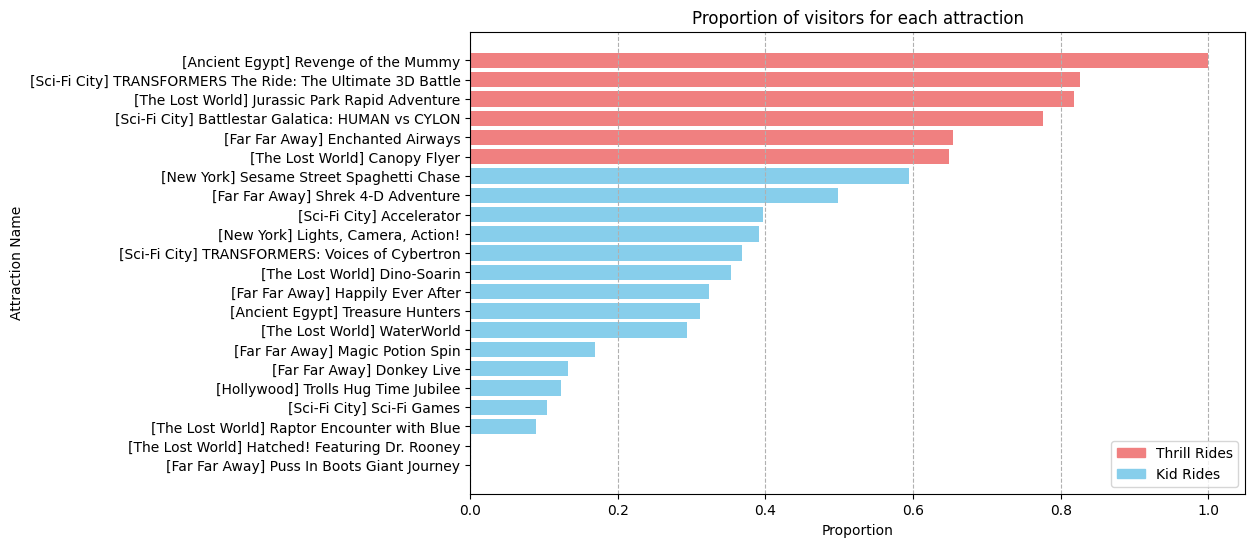

In [135]:
df = attractions_df.sort_values(by='proportion', ascending=True)
colors = ['skyblue' if label == 1 else 'lightcoral' for label in df['kid_or_thrill']]

plt.figure(figsize=(10, 6))
plt.barh(df['attraction_name'], df['proportion'], color=colors)
plt.xlabel('Proportion')
plt.ylabel('Attraction Name')
plt.title('Proportion of visitors for each attraction')
plt.grid(axis='x', linestyle='--')

legend_elements = [
    mpatches.Patch(color='lightcoral', label='Thrill Rides'),
    mpatches.Patch(color='skyblue', label='Kid Rides')
]
plt.legend(handles=legend_elements, loc='lower right')

plt.show()

Do the same for food outlets and stores.

In [136]:
food_outlets_in_survey = survey_data['if your answer was "yes" above, which food outlet(s) did you visit? (select all that apply)']

food_outlet_count = defaultdict(int)
for entry in food_outlets_in_survey:
        if isinstance(entry, str):
                for outlet in food_outlet_names:
                        if outlet in entry:
                                food_outlet_count[outlet] += 1
    
food_outlet_count_df = pd.DataFrame(list(food_outlet_count.items()), columns=['food_outlet_name', 'visit_count'])

food_outlets_df = pd.DataFrame({
        "food_outlet_name": food_outlet_names
})
food_outlets_df = food_outlets_df.merge(food_outlet_count_df, on='food_outlet_name', how='left')
food_outlets_df['visit_count'] = food_outlets_df['visit_count'].fillna(0).astype(int)

# compute proportion and popularity factor
food_outlets_df['proportion'] = food_outlets_df['visit_count'] / food_outlets_df['visit_count'].max()
food_outlets_df['popularity_factor'] = food_outlets_df['visit_count'] / food_outlets_df['visit_count'].max() * 2

food_outlets_df

,food_outlet_name,visit_count,proportion,popularity_factor
0,[Hollywood] Mel's Drive-In,1600,1.000000,2.00000
1,[Hollywood] Pops! Popcorn Delight,0,0.000000,0.00000
2,[Hollywood] Starbucks,1500,0.937500,1.87500
3,[New York] KT's Grill,0,0.000000,0.00000
4,[New York] Loui's NY Pizza Parlour,946,0.591250,1.18250
5,[New York] Me Want Cookie!,102,0.063750,0.12750
6,[Sci-Fi City] Frozen Fuel,793,0.495625,0.99125
7,[Sci-Fi City] Planet Yen,117,0.073125,0.14625
8,[Sci-Fi City] Starbot Cafe,225,0.140625,0.28125
9,[Sci-Fi City] Star Dots,581,0.363125,0.72625


In [137]:
stores_in_survey = survey_data['which store(s) did you visit? (select all that apply)']

store_count = defaultdict(int)
for entry in stores_in_survey:
        if isinstance(entry, str):
                for outlet in store_names:
                        if outlet in entry:
                                store_count[outlet] += 1
    
store_count_df = pd.DataFrame(list(store_count.items()), columns=['store_name', 'visit_count'])

stores_df = pd.DataFrame({
        "store_name": store_names
})
stores_df = stores_df.merge(store_count_df, on='store_name', how='left')
stores_df['visit_count'] = stores_df['visit_count'].fillna(0).astype(int)

# compute proportion and popularity factor
stores_df['proportion'] = stores_df['visit_count'] / stores_df['visit_count'].max()
stores_df['popularity_factor'] = stores_df['visit_count'] / stores_df['visit_count'].max() * 2

stores_df

,store_name,visit_count,proportion,popularity_factor
0,[Hollywood] Universal Studios Store,2590,1.000000,2.000000
1,[Hollywood] Minion Mart,2260,0.872587,1.745174
2,[Hollywood] Hello Kitty Studio Store,486,0.187645,0.375290
3,[Hollywood] The Dark Room,169,0.065251,0.130502
4,[Hollywood] Candylicious,769,0.296911,0.593822
5,[New York] Big Bird's Emporium,322,0.124324,0.248649
6,[Sci-Fi City] Transformers Supply Vault,490,0.189189,0.378378
7,[The Lost World] The Dino-Store,819,0.316216,0.632432
8,[Far Far Away] Fairy Godmother's Potion Shop,1475,0.569498,1.138996


# Analysis of average wait time for attractions, and testing

This section determines the components of the time series model for daily average wait time, then tests the model.

As only data from 2023 and 2024 are real, we will be doing analysis and modelling on data from 2023 till August 2024 and evaluate on Sep-Oct 2024 data.

## Analysis

This section analyses the existence of trends, and the acf, pacf to obtain $(p,d,q)\times (P,D,Q)_s$.

In [138]:
daily_wait_time_df = combined_wait_time_df.groupby(['date'])['wait_time'].mean().reset_index()
daily_wait_time_df.columns = ['date', 'avg_wait_time'] # rename columns
daily_wait_time_df['date'] = pd.to_datetime(daily_wait_time_df['date'])

first_train_date = pd.to_datetime('2023-01-01')
last_train_date = pd.to_datetime('2024-08-31')
train_wait_time_df = daily_wait_time_df[(daily_wait_time_df['date'] >= first_train_date) & (daily_wait_time_df['date'] <= last_train_date)].reset_index(drop=True)
train_wait_time_df.head()

,date,avg_wait_time
0,2023-01-02,35.583333
1,2023-01-04,30.904762
2,2023-01-05,22.964286
3,2023-01-06,23.178571
4,2023-01-07,20.119048


Analyse the acf and pacf plots of daily average wait time -- how much does a day's average wait time depend on the previous day's average wait time?

Note that a SARIMA model has components $(p,d,q)\times (P,D,Q)_s$ where $(p,d,q)$ are for within season and $(P,D,Q)$ is across seasons.

First we check for stationarity by plotting wait time against daily average as shown below.

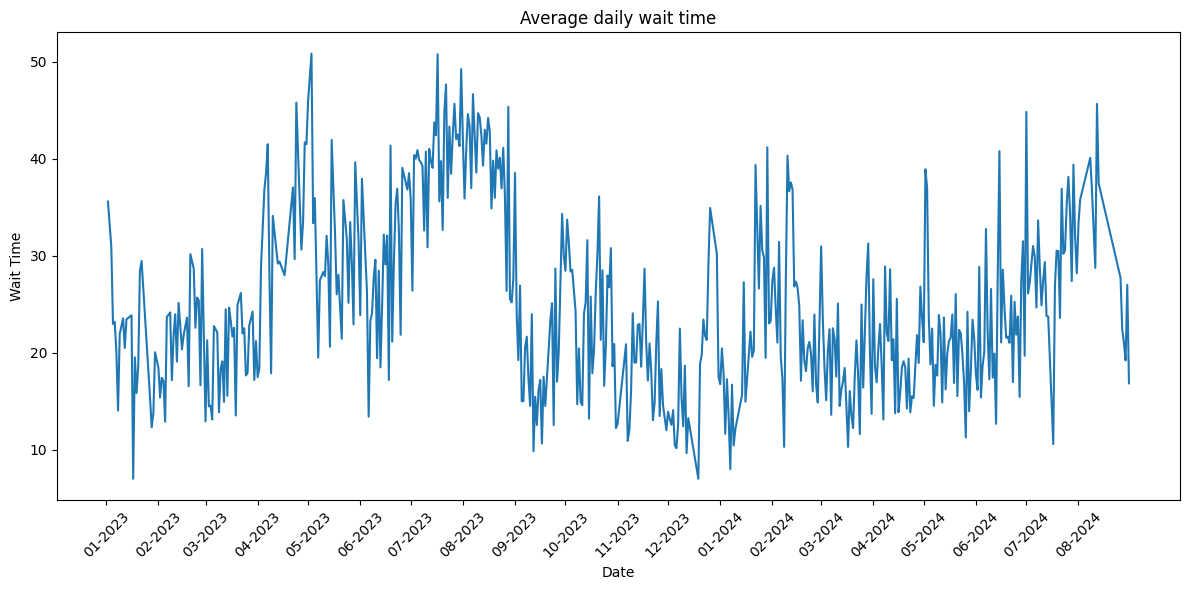

In [139]:
plt.figure(figsize=(12, 6))
plt.plot(train_wait_time_df['date'], train_wait_time_df['avg_wait_time'])
plt.title('Average daily wait time')
plt.xlabel('Date')
plt.ylabel('Wait Time')

month_labels = pd.date_range(start=first_train_date, end=last_train_date, freq='MS').strftime('%m-%Y').tolist()
plt.xticks(pd.date_range(start=first_train_date, end=last_train_date, freq='MS'), month_labels, rotation=45)
plt.tight_layout()
plt.show()

There exists some heteroskedasticity, and it is clearly not stationary. 

A log transformation as well as a difference operator is applied to the average wait time.

In [140]:
train_wait_time_df['log_wait_time'] = np.log(train_wait_time_df['avg_wait_time'])
train_wait_time_df['diff_wait_time'] = train_wait_time_df['log_wait_time'].diff(periods=1)

The Augmented Dickey-Fuller (ADF) test is used to statistically determine if the series is stationary.

In [141]:
# Augmented Dickey-Fuller (ADF) test
result = adfuller(train_wait_time_df['log_wait_time'])
print('p-value before differencing:', result[1])

# check for d=1
result_d = adfuller(train_wait_time_df['diff_wait_time'].dropna())
print('p-value after differencing:', result_d[1])

p-value before differencing: 0.09731716697543957
p-value after differencing: 7.09099217824306e-13


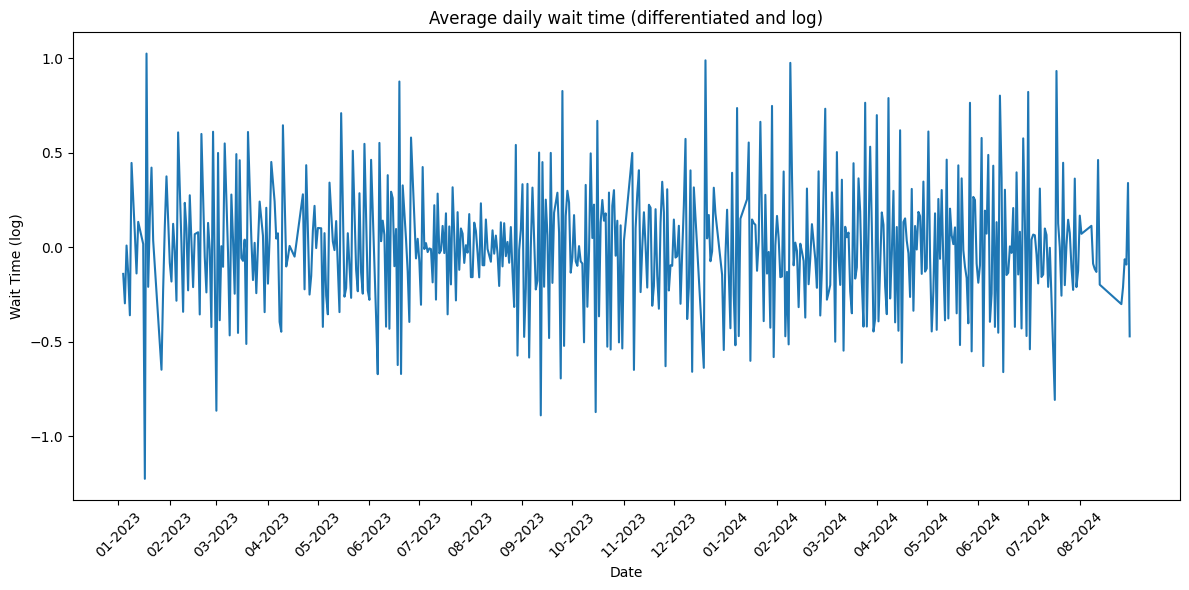

In [142]:
plt.figure(figsize=(12, 6))
plt.plot(train_wait_time_df['date'], train_wait_time_df['diff_wait_time'])
plt.title('Average daily wait time (differentiated and log)')
plt.xlabel('Date')
plt.ylabel('Wait Time (log)')

month_labels = pd.date_range(start=first_train_date, end=last_train_date, freq='MS').strftime('%m-%Y').tolist()
plt.xticks(pd.date_range(start=first_train_date, end=last_train_date, freq='MS'), month_labels, rotation=45)
plt.tight_layout()
plt.show()

A more stationary result is achieved. Hence, $d=1$.

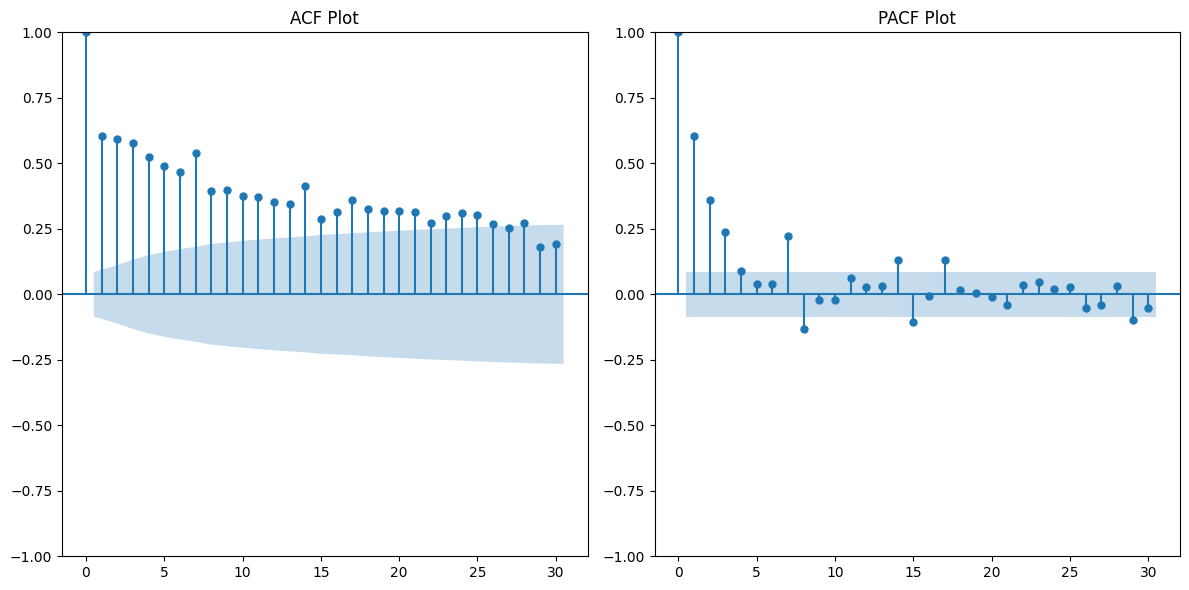

In [143]:
# Plot ACF
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_acf(train_wait_time_df['log_wait_time'], lags=30, ax=plt.gca())
plt.title('ACF Plot')

# Plot PACF
plt.subplot(1, 2, 2)
plot_pacf(train_wait_time_df['log_wait_time'], lags=30, ax=plt.gca())
plt.title('PACF Plot')

plt.tight_layout()
plt.show()

There is a slow decay in the ACF plot, indicating the presence of a trend in the data. In particular, there is some correlation at lags 0, 7, 14 which corresponds to weekly seasonality in the data. Hence, $s=7$.

There is a drop at lag 4 in the PACF plot, indicating that the time series has some level of dependency up to 3 lags. Hence, $p=3$.

As $q$ cannot be selected from the ACF plot, we will start with a small number, $q=1$.


In [144]:
# apply seasonal differencing (D=1)
train_wait_time_df['seasonal_diff'] = train_wait_time_df['log_wait_time'].diff(periods=1)
result_D = adfuller(train_wait_time_df['seasonal_diff'].dropna())
print('p-value after seasonal differencing:', result_D[1])

p-value after seasonal differencing: 7.09099217824306e-13


In [145]:
nlags = 30  # no. of lags to consider
acf_values = acf(train_wait_time_df['log_wait_time'], nlags=nlags)
pacf_values = pacf(train_wait_time_df['log_wait_time'], nlags=nlags)

seasonal_lags = [7, 14]  # Adjust based on your data length and requirements
seasonal_acf = [acf_values[lag] for lag in seasonal_lags]
seasonal_pacf = [pacf_values[lag] for lag in seasonal_lags]

print(f"Seasonal ACF values at lags 7, 14: {[round(value.item(),3) for value in seasonal_acf]}")
print(f"Seasonal PACF values at lags 7, 14: {[round(value.item(),3) for value in seasonal_pacf]}")

Seasonal ACF values at lags 7, 14: [0.539, 0.415]
Seasonal PACF values at lags 7, 14: [0.229, 0.138]


PACF(7) is significant and PACF(14) is not as significant. Hence, $P=1$.

ACF(7) and ACF(14) are significant. Hence, $Q=1$.

The model will be SARIMA $(3,1,1)\times (1,1,1)_7$.

## Test the model predicting average wait time of attractions

As there is a difference operator of 1, if we were to train on 2023 data and apply it to 2024 data, the wait time will increase linearly without following any pattern that we may have found from the analysis step. The predicted wait time will also differ for different dates that the model is trained on.

Hence, we will implement a sliding window by using only data from the past 3 months (90 days) to train the model to predict the next day's wait time.

First, the skipped days will be imputed with the mean wait time instead of, say, forward or backward filling, as it prevents the introduction of artificial trends or seasonality. It also ensures that the model’s assumptions of stationarity (constant mean and variance over time) hold.

In real life, we want to predict the demand for the next few days and allocate the appropriate number of staff to work that day. Assuming that work schedules are released weekly, we will predict the wait time for the next 7 days. It was also found that the prediction of the next 7 days was the best and most applicable among the following options tested (1, 7, 14, 30 days). 

In [146]:
# 2023-2024 data
wait_time_23_24 = daily_wait_time_df[daily_wait_time_df['date'] >= first_train_date].reset_index(drop=True)
wait_time_23_24['date'] = pd.to_datetime(wait_time_23_24['date'])

In [147]:
full_date_df = pd.DataFrame({'date': pd.date_range(start=wait_time_23_24['date'].min(), end=wait_time_23_24['date'].max())})

#left join
full_wait_time_df = pd.merge(full_date_df, wait_time_23_24, on='date', how='left')

# fill NA values with the mean
full_wait_time_df['avg_wait_time'] = full_wait_time_df['avg_wait_time'].fillna(full_wait_time_df['avg_wait_time'].mean())

In [148]:
# function to obtain next n days of demand (wait time)
def predict_n_days(window_size, df, n):
    """
    parameters:
    window_size: sliding window size
    df: wait time df. df should be cleaned, i.e. no skipped days
    n: predict the next n days
    the SARIMA model is (3,1,1)x(1,1,1)_7

    returns:
    forecast_df: df of dates and forecasted wait times
    coef_list: list; for each window, the coefficients and p-values
    """
    first_date = df['date'].min()
    last_date = df['date'].max()
    num_days = (last_date - first_date).days

    # log
    df['log_wait_time'] = np.log(df['avg_wait_time'])

    forecast_results = []
    forecast_dates = []
    coef_list = []

    for i in range(0, num_days - window_size, n):
        train_window = df['log_wait_time'].iloc[i:i + window_size]

        # fit the SARIMA model on the current training window
        model = SARIMAX(train_window, order=(3, 1, 1), seasonal_order=(1, 1, 1, 7),
                        enforce_stationarity=False, 
                        enforce_invertibility=False)
        results = model.fit(disp=False, maxiter=500)

        # forecast the next n days
        forecast = results.get_forecast(steps=n)
        forecast_vals = np.exp(forecast.predicted_mean)

        # Store each of the n forecasted days
        for j in range(n):
            forecast_results.append(forecast_vals.iloc[j])
            forecast_dates.append(df['date'].iloc[i + window_size] + pd.Timedelta(days=j))

        coef_list.append({
            'window_start': df['date'].iloc[i],
            'window_end': df['date'].iloc[i+window_size],
            'coefficients': results.params,
            'pvalues': results.pvalues
        })

    # Create a DataFrame for the forecast results
    forecast_df = pd.DataFrame({'date': forecast_dates, 'forecast': forecast_results})
    forecast_df['date'] = pd.to_datetime(forecast_df['date'])

    return forecast_df, coef_list

# function to plot actual vs forecasted wait time
def plot_predictions(actual_df, forecast_df):
    plt.figure(figsize=(12, 6))
    plt.plot(actual_df['date'], actual_df['avg_wait_time'], label='Actual', color='lightblue')
    plt.plot(forecast_df['date'], forecast_df['forecast'], label='Forecast', color='red')
    plt.title("SARIMA Forecast (sliding window)")
    plt.xlabel('Date')
    plt.ylabel('Wait Time')
    plt.legend()
    plt.show()

# compute mae, rmse and mape
def compute_metrics(actual_with_mean_df, forecast_df):
    joined = actual_with_mean_df.merge(forecast_df, on='date', how='inner')

    # mean absolute error
    mae = np.mean(np.abs(joined['avg_wait_time'] - joined['forecast']))

    # root mean square error
    rmse = root_mean_squared_error(joined['avg_wait_time'], joined['forecast'])

    # mean absolute percentage error
    mape = np.mean(np.abs((joined['avg_wait_time'] - joined['forecast']) / joined['avg_wait_time'])) * 100

    return {'mae': mae,
            'rmse': rmse,
            'mape': mape}

def plot_pvalues(coef_list):
    """
    input: list of dictionaries
        each dictionary: 'window_start', 'window_end', 'coefficients', 'pvalues'
    
    output:
    a plot visualising the p-value of each coefficient with significance level of 0.05
    """
    pvalues_df = pd.DataFrame([{
        'window_start': result['window_start'],
        'pvalues': result['pvalues'].to_dict()
    } for result in coef_list]) 

    # change to long table
    pvalues_long = pd.concat([
        pd.DataFrame({'window_start': row['window_start'], 'parameter': list(row['pvalues'].keys()), 'pvalue': list(row['pvalues'].values())})
        for _, row in pvalues_df.iterrows()
    ], ignore_index=True)

    # unique parameters
    unique_parameters = pvalues_long['parameter'].unique()

    # plot
    plt.figure(figsize=(10, 6))
    
    for param in unique_parameters:
        subset = pvalues_long[pvalues_long['parameter'] == param]
        
        # add jitter by generating random noise
        jittered_x = np.random.normal(loc=subset['parameter'].apply(unique_parameters.tolist().index), scale=0.05)
        
        # plot with light opacity to show overlap
        plt.scatter(jittered_x, subset['pvalue'], color='blue', alpha=0.2, s=50)

    # Customizations
    plt.xlabel('Parameter')
    plt.ylabel('P-Value')
    plt.title('P-Values of Parameters Across Time Windows')
    plt.xticks(ticks=range(len(unique_parameters)), labels=unique_parameters, rotation=45)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.axhline(y=0.05, color='red', linestyle='--', label='Significance Threshold (0.05)')

    plt.tight_layout()
    plt.show()

def plot_coefficients(coef_list):
    """
    input: list of dictionaries
        each dictionary: 'window_start', 'window_end', 'coefficients', 'pvalues'
    
    output:
    a plot visualising the value of each coefficient
    """
    coef_df = pd.DataFrame([{
        'window_start': result['window_start'],
        'coefficients': result['coefficients'].to_dict()
    } for result in coef_list]) 

    # change to long table
    coef_df_long = pd.concat([
        pd.DataFrame({'window_start': row['window_start'], 'parameter': list(row['coefficients'].keys()), 'coefficients': list(row['coefficients'].values())})
        for _, row in coef_df.iterrows()
    ], ignore_index=True)

    # unique parameters
    unique_parameters = coef_df_long['parameter'].unique()

    # plot
    plt.figure(figsize=(10, 6))
    
    for param in unique_parameters:
        subset = coef_df_long[coef_df_long['parameter'] == param]
        
        # add jitter by generating random noise
        jittered_x = np.random.normal(loc=subset['parameter'].apply(unique_parameters.tolist().index), scale=0.05)
        
        # plot with light opacity to show overlap
        plt.scatter(jittered_x, subset['coefficients'], color='blue', alpha=0.2, s=50)

    # Customizations
    plt.xlabel('Parameter')
    plt.ylabel('Value of coefficient')
    plt.title('Coefficients of Parameters Across Time Windows')
    plt.xticks(ticks=range(len(unique_parameters)), labels=unique_parameters, rotation=45)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

/Users/jinlynn/DSA3101-2410/penv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


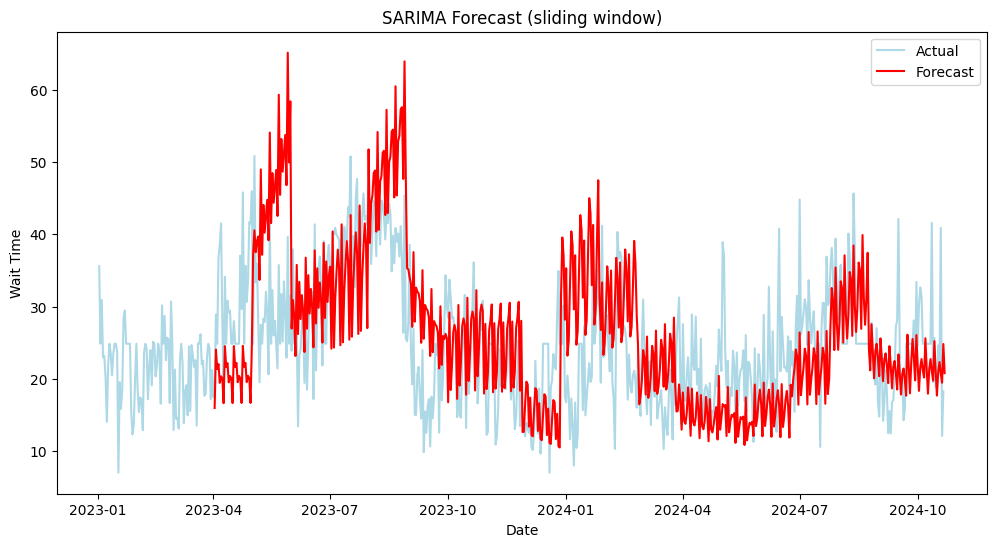

{'mae': np.float64(7.472141062027424),
 'rmse': np.float64(9.465870829648521),
 'mape': np.float64(32.35896549146622)}

In [149]:
forecast_df, coef_list = predict_n_days(90, full_wait_time_df, 30)
plot_predictions(full_wait_time_df, forecast_df)
compute_metrics(full_wait_time_df, forecast_df)

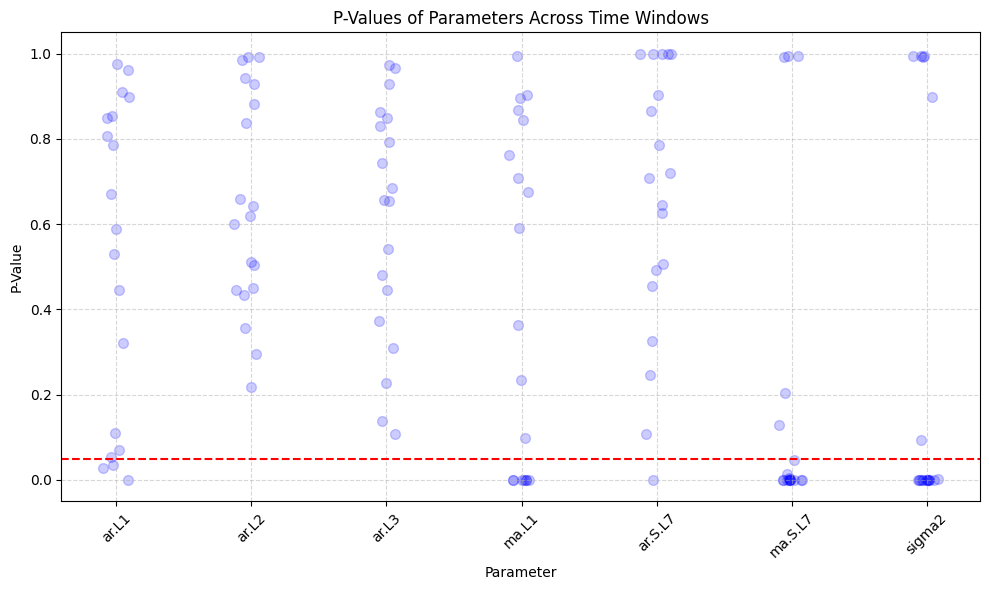

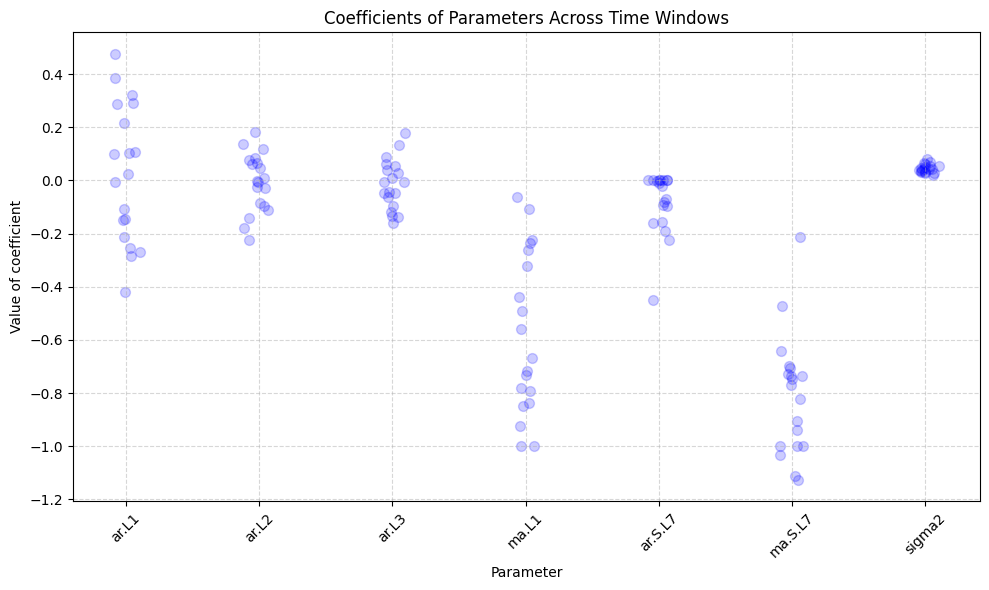

In [150]:
plot_pvalues(coef_list)
plot_coefficients(coef_list)

From the above 2 plots, the non-seasonal AR component seems to be higher than required.

The p-values for ar.L2 and ar.L3 are high, and their coefficients are near 0.

The seasonal AR component seems to be not significant as its p-values are high and its coefficients are near 0.

Below, we change p from 3 to 1, and P from 1 to 0. Hence, SARIMA $(1, 1, 1)\times(0, 1, 1)_7$. 

Additionally while day of week (weekly seasonality) has been identified as influential, other time factors such as:

- seasonality (eg. public and school holidays), and
- promotional events (eg. Halloween Horror Nights)

are not captured in the time analysis.

In [151]:
# rewrite predict_n_days function
# function to obtain next n days of demand (wait time)
def predict_n_days(window_size, df, n):
    """
    parameters:
    window_size: sliding window size
    df: wait time df. df should be cleaned, i.e. no skipped days
    n: predict the next n days
    the SARIMA model is (1,1,1)x(0,1,1)_7

    returns:
    forecast_df: df of dates and forecasted wait times
    coef_list: list; for each window, the coefficients and p-values
    """
    first_date = df['date'].min()
    last_date = df['date'].max()
    num_days = (last_date - first_date).days

    # log
    df['log_wait_time'] = np.log(df['avg_wait_time'])
    
    # add columns to indicate public/school holiday
    df['is_holiday'] = df['date'].apply(is_public_or_school_holiday)

    forecast_results = []
    forecast_dates = []
    coef_list = []

    for i in range(0, num_days - window_size - n, n):
        train_window = df['log_wait_time'].iloc[i:i + window_size].reset_index(drop=True)

        exog_train = pd.DataFrame({
            'is_holiday': df['is_holiday'].iloc[i:i + window_size].values
        }).reset_index(drop=True)

        # fit the SARIMA model on the current training window
        model = SARIMAX(train_window, order=(1, 1, 1), seasonal_order=(0, 1, 1, 7),
                        exog=exog_train,
                        enforce_stationarity=False, 
                        enforce_invertibility=False)
        results = model.fit(disp=False, maxiter=500)

        exog_forecast = pd.DataFrame({
            'is_holiday': df['is_holiday'].iloc[i + window_size:i + window_size + n].values
        }).reset_index(drop=True)

        # forecast the next n days
        forecast = results.get_forecast(steps=n, exog=exog_forecast)
        forecast_vals = np.exp(forecast.predicted_mean)

        # Store each of the n forecasted days
        for j in range(n):
            forecast_results.append(forecast_vals.iloc[j])
            forecast_dates.append(df['date'].iloc[i + window_size] + pd.Timedelta(days=j))

        coef_list.append({
            'window_start': df['date'].iloc[i],
            'window_end': df['date'].iloc[i+window_size],
            'coefficients': results.params,
            'pvalues': results.pvalues
        })

    # Create a DataFrame for the forecast results
    forecast_df = pd.DataFrame({'date': forecast_dates, 'forecast': forecast_results})
    forecast_df['date'] = pd.to_datetime(forecast_df['date'])

    return forecast_df, coef_list

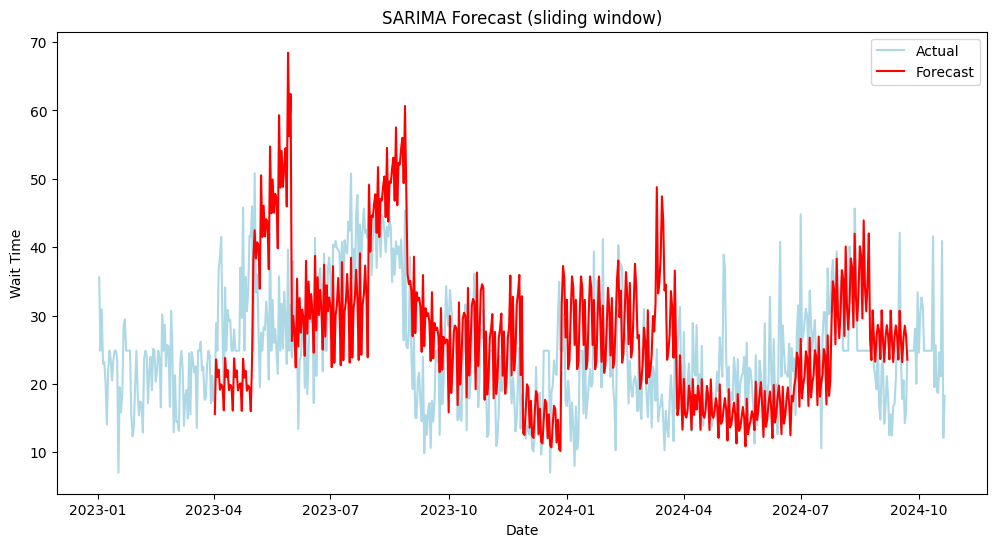

{'mae': np.float64(8.056436845501898),
 'rmse': np.float64(10.083456167941911),
 'mape': np.float64(35.69473133140919)}

In [152]:
forecast_df, coef_list = predict_n_days(90, full_wait_time_df, 30)
plot_predictions(full_wait_time_df, forecast_df)
compute_metrics(full_wait_time_df, forecast_df)

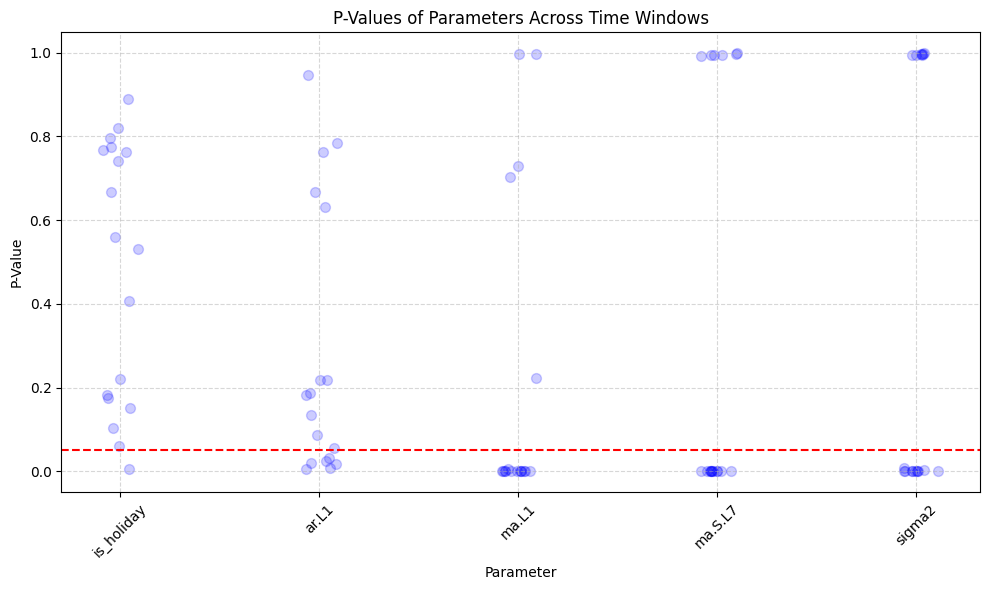

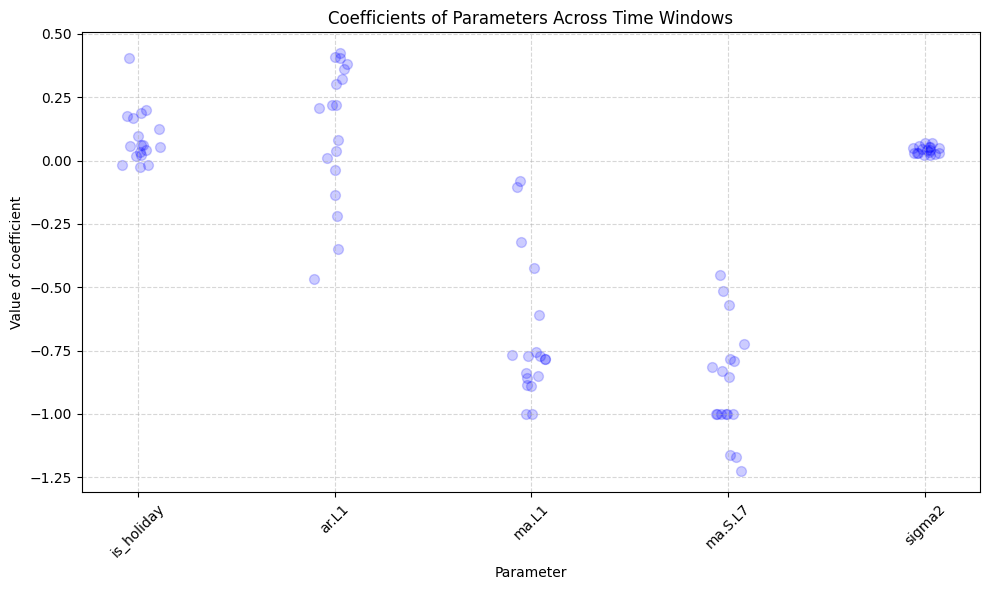

In [153]:
plot_pvalues(coef_list)
plot_coefficients(coef_list)

We found that is_hhn has little significance to the model, while is_holiday has some significance.

The  metrics for the refined model produce a slightly larger MAE but smaller RMSE and MAPE, indicating improved performance. The plots also show improvement.

Hence, the model we proceed with is SARIMA $(1,1,1)\times (0,1,1)_7$ with the exogenous factor is_holiday. The equation is as follows:

$$Y_t = \phi_1 Y_{t-1} + \theta_1 e_{t-1} + e_t + Y_{t-7}+ \theta_2 e_{t-7} +\beta_1 X_{1,t}$$
where:
- $Y_i$: wait time at time stamp i
- $e_i$: error term at time stamp i
- $X_{1,i}$: indication of whether time stamp i is a public/school holiday

# Model for specific attractions

The data collected is only the wait time averaged across all rides. We will estimate the wait time for each attraction using its popularity factor.

For the prediction model, the same sliding window technique is used, and we will incorporate exogenous factors:
- indoor/outdoor
- kid-friendly/thrill
- weather data

then evaluate if these factors are significant in the model.

Additionally, while day of week (weekly seasonality) has been identified as influential, other time factors such as:

- seasonality (eg. public and school holidays), and
- promotional events (eg. Halloween Horror Nights)

are not captured in the time analysis. These will also be included in the model and evaluated.

In [154]:
def get_estimated_wait_time_for_attraction(wait_time_df, attractions_df, attraction_name):
    """
    parameters:
    wait_time_df: average wait time across all attractions
    attractions_df: contains information on is_indoor, kid_or_thrill and popularity_factor
    attraction_name: name of attraction to estimate on
    
    returns:
    a df of estimated wait time for the attraction.
    columns: date, avg_wait_time
    """
    
    pop_factor = attractions_df.loc[attractions_df['attraction_name'] == attraction_name, 'popularity_factor'].iloc[0]
    est_wait_time = wait_time_df['avg_wait_time'] * pop_factor
    est_wait_time_df = pd.DataFrame({
        'date': wait_time_df['date'],
        'avg_wait_time': est_wait_time
    })
    return est_wait_time_df

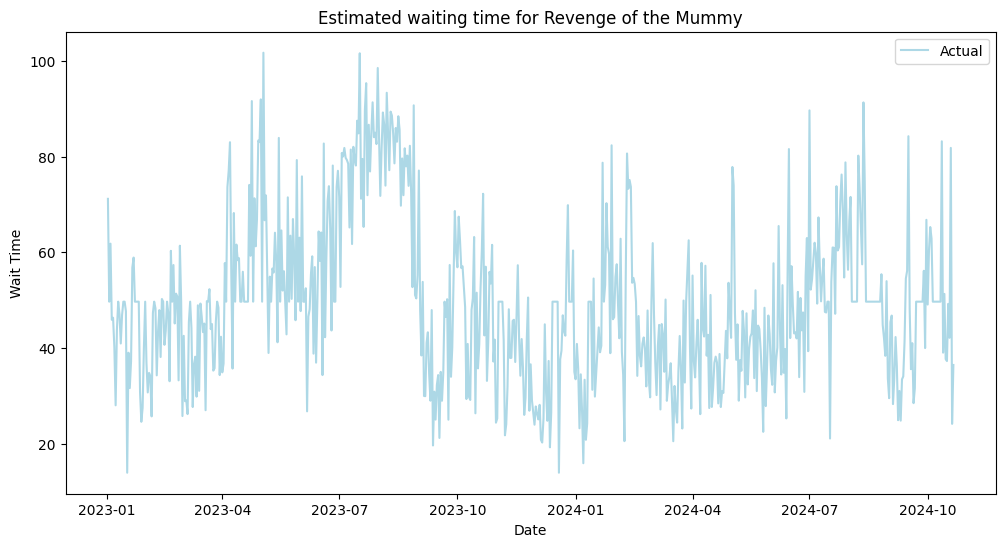

In [155]:
# example on "[Ancient Egypt] Revenge of the Mummy"
revenge_of_the_mummy_wait_time = get_estimated_wait_time_for_attraction(full_wait_time_df, attractions_df, "[Ancient Egypt] Revenge of the Mummy")

plt.figure(figsize=(12, 6))
plt.plot(revenge_of_the_mummy_wait_time['date'], revenge_of_the_mummy_wait_time['avg_wait_time'], label='Actual', color='lightblue')
plt.title("Estimated waiting time for Revenge of the Mummy")
plt.xlabel('Date')
plt.ylabel('Wait Time')
plt.legend()
plt.show()

In [176]:
def predict_ride_n_days(attraction_name, wait_time_df, attractions_df, weather_df, window_size, n):
    """
    parameters:
    attraction_name: name of attraction to predict on
    wait_time_df: average wait time df across all rides
    attractions_df: contains information on is_indoor, kid_or_thrill and popularity_factor
    weather_df: daily precipitation levels
    window_size: sliding window size
    n: predict for next n days
    
    returns:
    - actual estimated wait time df for the ride with the dates and wait times
    - forecasted wait time df with the dates and forecasted wait times
    """
    ride_wait_time_df = get_estimated_wait_time_for_attraction(wait_time_df, attractions_df, attraction_name)
    is_indoor = attractions_df.loc[attractions_df['attraction_name'] == attraction_name, 'is_indoor'].iloc[0]
    kid_or_thrill = attractions_df.loc[attractions_df['attraction_name'] == attraction_name, 'kid_or_thrill'].iloc[0]

    # merge ride_wait_time_df and weather_df for common dates
    df = ride_wait_time_df.merge(weather_df, on='date', how='inner')
    # log
    df['log_wait_time'] = np.log(df['avg_wait_time'])

    # add columns to indicate public/school holiday
    df['is_holiday'] = df['date'].apply(is_public_or_school_holiday)

    first_date = df['date'].min()
    last_date = df['date'].max()
    num_days = (last_date - first_date).days

    forecast_results = []
    forecast_dates = []
    coef_list = []

    for i in range(0, num_days - window_size - n, n):
        train_window = df['log_wait_time'].iloc[i:i + window_size].reset_index(drop=True)

        exog_train = pd.DataFrame({
            'is_indoor': [is_indoor] * window_size,
            'kid_or_thrill': [kid_or_thrill] * window_size,
            'precipitation': df['precipitation'].iloc[i:i + window_size].values,
            'is_holiday': df['is_holiday'].iloc[i:i + window_size].values
        }).reset_index(drop=True)

        # fit the SARIMA model on the current training window
        model = SARIMAX(train_window, order=(1, 1, 1), seasonal_order=(0, 1, 1, 7),
                        exog=exog_train,
                        enforce_stationarity=False, 
                        enforce_invertibility=False)
        results = model.fit(disp=False, maxiter=500)

        exog_forecast = pd.DataFrame({
            'is_indoor': [is_indoor] * n,
            'kid_or_thrill': [kid_or_thrill] * n,
            'precipitation': df['precipitation'].iloc[i + window_size:i + window_size + n].values,
            'is_holiday': df['is_holiday'].iloc[i + window_size:i + window_size + n].values
        }).reset_index(drop=True)

        # forecast the next n days
        forecast = results.get_forecast(steps=n, exog=exog_forecast)
        forecast_vals = np.exp(forecast.predicted_mean)

        # Store each of the n forecasted days
        for j in range(n):
            forecast_results.append(forecast_vals.iloc[j])
            forecast_dates.append(df['date'].iloc[i + window_size] + pd.Timedelta(days=j))

        # Store the coef and p-values
        coef_list.append({
            'window_start': df['date'].iloc[i],
            'window_end': df['date'].iloc[i+window_size],
            'coefficients': results.params,
            'pvalues': results.pvalues
        })

    # Create a DataFrame for the forecast results
    forecast_df = pd.DataFrame({'date': forecast_dates, 'forecast': forecast_results})
    forecast_df['date'] = pd.to_datetime(forecast_df['date'])

    return ride_wait_time_df, forecast_df, coef_list

In [177]:
revenge_of_the_mummy_wait_time, revenge_of_the_mummy_forecast, revenge_of_the_mummy_coef_list = predict_ride_n_days("[Ancient Egypt] Revenge of the Mummy", full_wait_time_df, attractions_df, weather_df, 90, 14)

/Users/jinlynn/DSA3101-2410/penv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


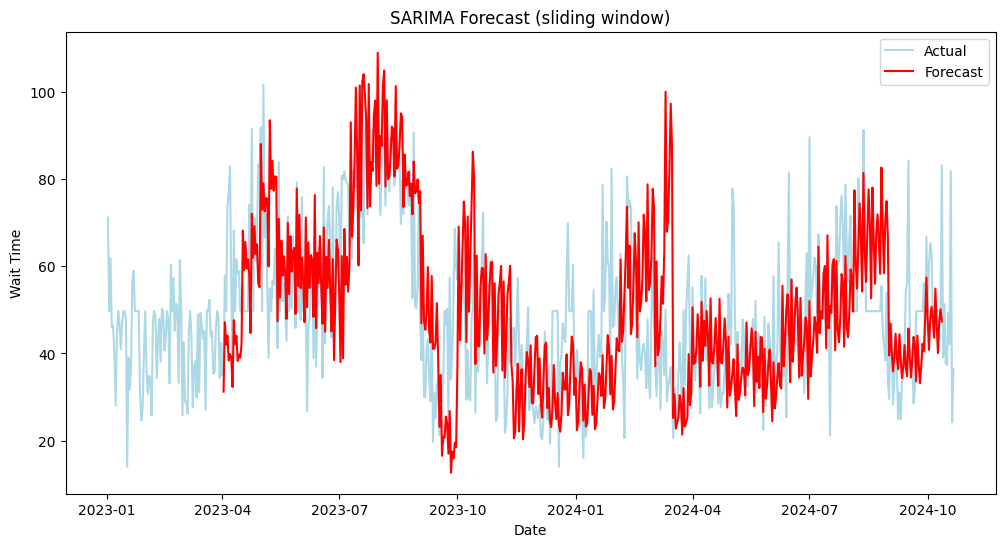

In [178]:
plot_predictions(revenge_of_the_mummy_wait_time, revenge_of_the_mummy_forecast)

In [179]:
compute_metrics(revenge_of_the_mummy_wait_time, revenge_of_the_mummy_forecast)

{'mae': np.float64(12.29014331988161),
 'rmse': np.float64(15.937580277739901),
 'mape': np.float64(26.491379838318696)}

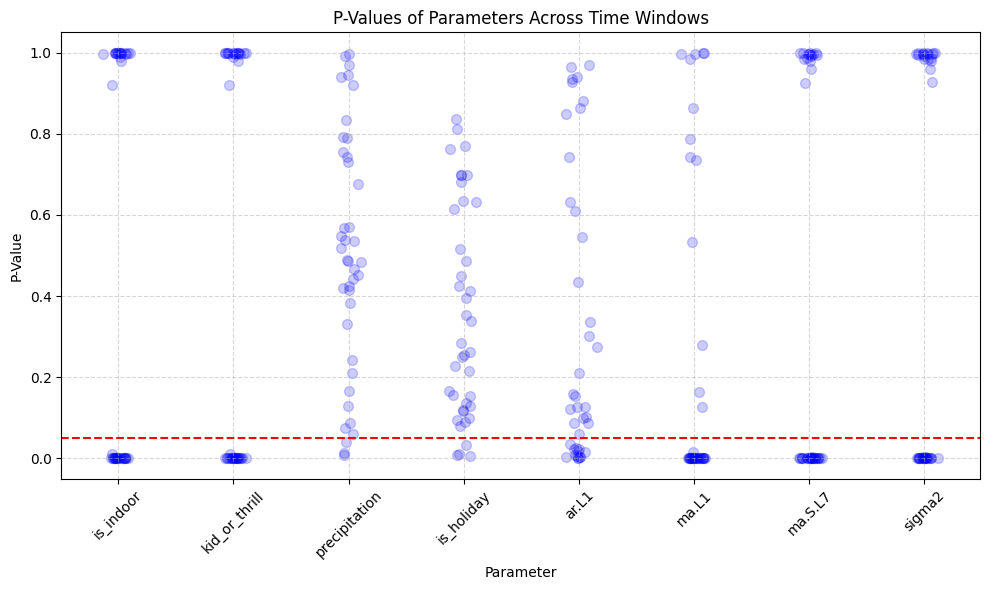

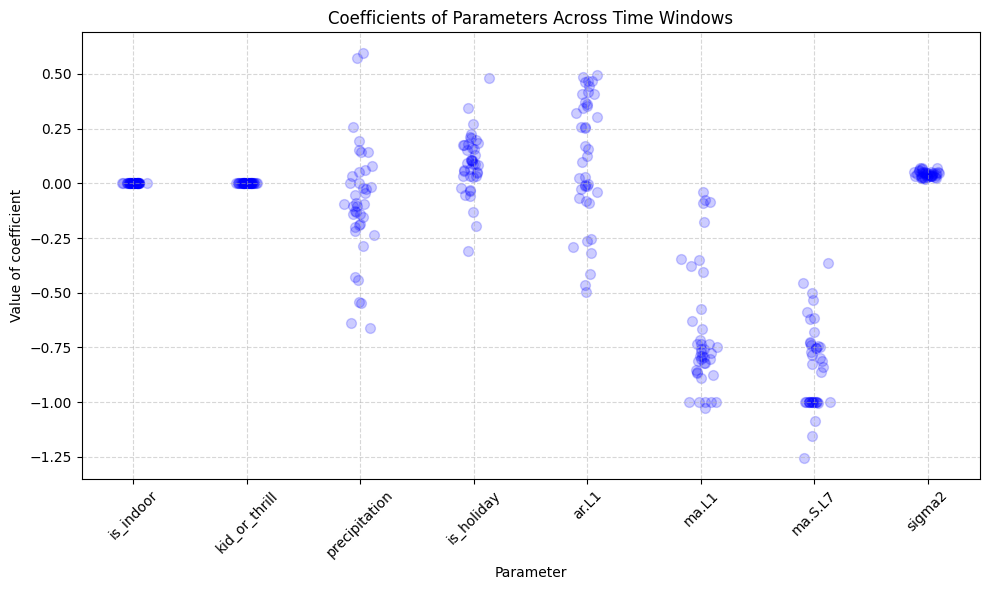

In [180]:
plot_pvalues(revenge_of_the_mummy_coef_list)
plot_coefficients(revenge_of_the_mummy_coef_list)

The following factors:
- is_indoor
- kid_or_thrill

generally have high p-values and coefficients near 0, indicating insignificance in the model.

Specifically, kid_or_thrill may hold little relevance, as ride popularity is already categorized into kid-friendly and thrill rides. With our sliding window approach, the wait times from the previous day are directly proportional to each ride's popularity, further diminishing the need for this variable.

Additionally, precipitation levels vary between -0.7 to 0.6, with random p-values. This suggests that increased rainfall can both decrease or increase wait times, depending on how visitors react to weather conditions. Hence, it is not predictable and does is not significant in the model.

Below, we remove these 3 factors and evaluate again.

In [191]:
# rewrite predict_ride_n_days function
def predict_ride_n_days(attraction_name, wait_time_df, attractions_df, weather_df, window_size, n):
    """
    parameters:
    attraction_name: name of attraction to predict on
    wait_time_df: average wait time df across all rides
    attractions_df: contains information on is_indoor, kid_or_thrill and popularity_factor
    weather_df: daily precipitation levels
    window_size: sliding window size
    n: predict for next n days
    
    returns:
    - actual estimated wait time df for the ride with the dates and wait times
    - forecasted wait time df with the dates and forecasted wait times
    """
    ride_wait_time_df = get_estimated_wait_time_for_attraction(wait_time_df, attractions_df, attraction_name)

    # merge ride_wait_time_df and weather_df for common dates
    df = ride_wait_time_df.merge(weather_df, on='date', how='inner')
    # log
    df['log_wait_time'] = np.log(df['avg_wait_time'])

    # add columns to indicate public/school holiday and hhn date
    df['is_holiday'] = df['date'].apply(is_public_or_school_holiday)

    first_date = df['date'].min()
    last_date = df['date'].max()
    num_days = (last_date - first_date).days

    forecast_results = []
    forecast_dates = []
    coef_list = []

    for i in range(0, num_days - window_size - n, n):
        train_window = df['log_wait_time'].iloc[i:i + window_size].reset_index(drop=True)

        exog_train = pd.DataFrame({
            'is_holiday': df['is_holiday'].iloc[i:i + window_size].values,
        }).reset_index(drop=True)

        # fit the SARIMA model on the current training window
        model = SARIMAX(train_window, order=(1, 1, 1), seasonal_order=(0, 1, 1, 7),
                        exog=exog_train,
                        enforce_stationarity=False, 
                        enforce_invertibility=False)
        results = model.fit(disp=False, maxiter=500)

        exog_forecast = pd.DataFrame({
            'is_holiday': df['is_holiday'].iloc[i + window_size:i + window_size + n].values,
        }).reset_index(drop=True)

        # forecast the next n days
        forecast = results.get_forecast(steps=n, 
                                        exog=exog_forecast
                                        )
        forecast_vals = np.exp(forecast.predicted_mean)

        # Store each of the n forecasted days
        for j in range(n):
            forecast_results.append(forecast_vals.iloc[j])
            forecast_dates.append(df['date'].iloc[i + window_size] + pd.Timedelta(days=j))

        # Store the coef and p-values
        coef_list.append({
            'window_start': df['date'].iloc[i],
            'window_end': df['date'].iloc[i+window_size],
            'coefficients': results.params,
            'pvalues': results.pvalues
        })

    # Create a DataFrame for the forecast results
    forecast_df = pd.DataFrame({'date': forecast_dates, 'forecast': forecast_results})
    forecast_df['date'] = pd.to_datetime(forecast_df['date'])

    return ride_wait_time_df, forecast_df, coef_list

In [192]:
revenge_of_the_mummy_wait_time, revenge_of_the_mummy_forecast, revenge_of_the_mummy_coef_list = predict_ride_n_days("[Ancient Egypt] Revenge of the Mummy", full_wait_time_df, attractions_df, weather_df, 90, 14)

/Users/jinlynn/DSA3101-2410/penv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


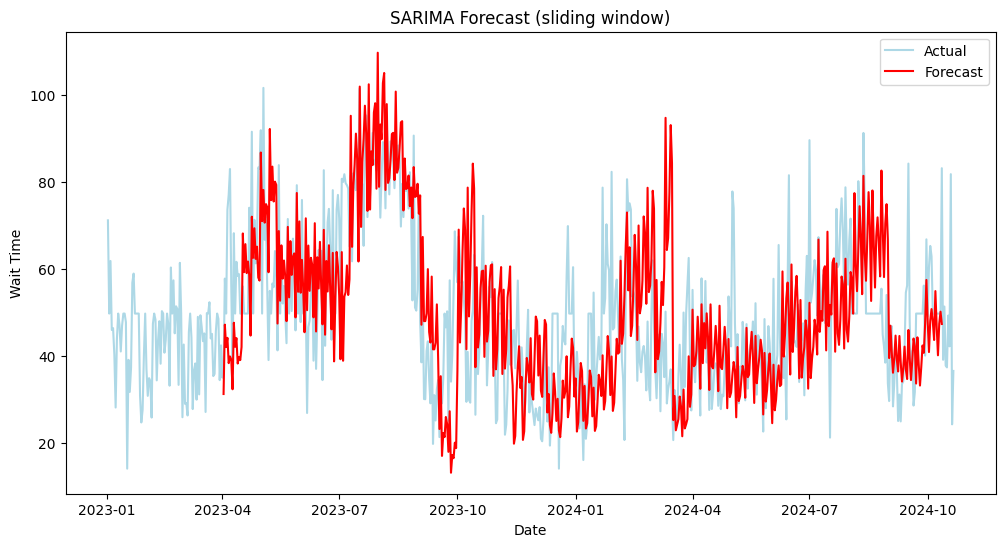

{'mae': np.float64(12.196422217960729),
 'rmse': np.float64(15.69283694813525),
 'mape': np.float64(26.424566947360123)}

In [193]:
plot_predictions(revenge_of_the_mummy_wait_time, revenge_of_the_mummy_forecast)
compute_metrics(revenge_of_the_mummy_wait_time, revenge_of_the_mummy_forecast)

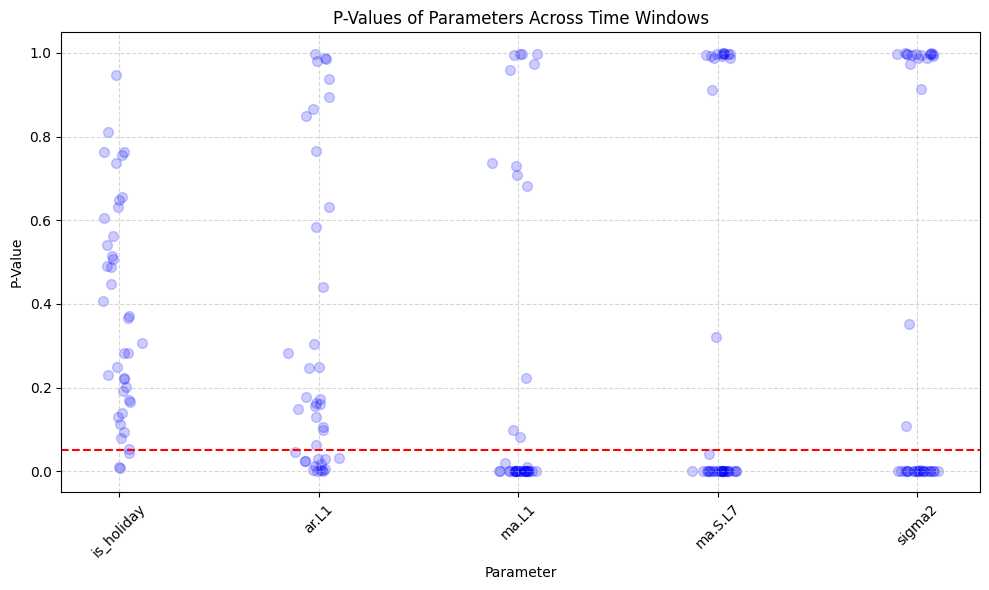

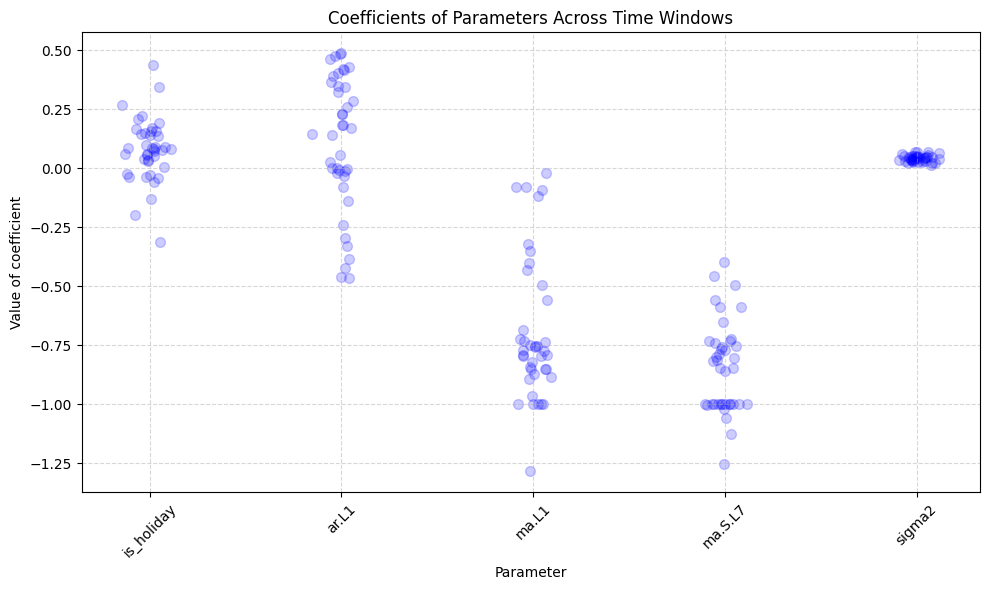

In [194]:
plot_pvalues(revenge_of_the_mummy_coef_list)
plot_coefficients(revenge_of_the_mummy_coef_list)

The metrics have increased slightly after the removal of some factors, but did not change drastically, so it is acceptable.

We have thus concluded that the influential factors are precipitation and public holiday.

$$Y_t = \phi_1 Y_{t-1} + \theta_1 e_{t-1} + e_t + Y_{t-7}+ \theta_2 e_{t-7} +\beta_1 X_{1,t}$$

where:
- $Y_i$: wait time at time stamp i
- $e_i$: error term at time stamp i
- $X_{1,i}$: indication of whether time stamp i is a public/school holiday

# Identification of key demand fluctuation factors and collating for each ride

For the most popular attraction,

$$Y_t = \phi_1 Y_{t-1} + \theta_1 e_{t-1} + e_t + Y_{t-7}+ \theta_2 e_{t-7} +\beta_1 X_{1,t}$$

where:
- $Y_i$: wait time at time stamp i
- $e_i$: error term at time stamp i
- $X_{1,i}$: indication of whether time stamp i is a public/school holiday

Previous wait time influence: The model considers the average wait time from the previous day, indicated by $Y_{t-1}$, with coefficient $\phi_1$. This means that if the wait time was high or low yesterday, it will have a direct effect on today’s expected wait time. $\phi_1$ is seen to range from -0.5 to 0.5, indicating that the previous day's wait time can both increase or decrease the current day's wait time.

Error correction: The model also incorporates the error from the previous day, represented by $e_{t-1}$, along with its coefficient, $\theta_1$. This allows the model to adjust based on discrepancies between predicted and actual wait times from the previous day. $\theta_1$ ranges from -1.25 to 0, indicating that previous errors tend to have a diminishing effect on current predictions.

Seasonal influence: Because wait times can vary by day of the week, we include the wait time from exactly one week ago, $Y_{t-7}$. This captures weekly patterns, such as longer wait times on certain days.

Seasonal error adjustment: Similar to the previous error term, we account for the error from the same day last week, $e_{t-7}$. This term helps the model correct predictions based on seasonal trends. Its coefficient $\theta_2$ ranges from -1.25 to -0.4, reflecting a significant negative impact from past seasonal discrepancies.

Exogenous factors: We also include external factors that can influence wait times:

Public/school holidays: Represented by $X_{1,t}$, this factor indicates whether the day is a public holiday. Its coefficient $\beta_1$ ranges from -0.25 to 0.5, indicating that holidays generally lead to increased visitor numbers and longer wait times.

The MAE (mean absolute error) is 12.2, which indicates that on average, the model makes a 10 minute error on the wait time. If the actual wait time was 30 minutes, the model would predict within a range of 18 to 42 minutes.

The MAPE (mean absolute percentage error) is 26.4, which is quite large. It is particularly bad if the actual wait time is large (eg. 100 minutes) as then the prediction error would be 26.4 minutes.

In [263]:
# rewrite predict_ride_n_days function
def predict_ride_n_days(attraction_name, wait_time_df, attractions_df, window_size, n):
    """
    parameters:
    attraction_name: name of attraction to predict on
    wait_time_df: average wait time df across all rides
    attractions_df: contains information on is_indoor, kid_or_thrill and popularity_factor
    window_size: sliding window size
    n: predict for next n days
    
    returns:
    - actual estimated wait time df for the ride with the dates and wait times
    - forecasted wait time df with the dates and forecasted wait times
    """
    ride_wait_time_df = get_estimated_wait_time_for_attraction(wait_time_df, attractions_df, attraction_name)

    df = ride_wait_time_df.copy()
    # log
    df['log_wait_time'] = np.log(df['avg_wait_time'])

    # add columns to indicate public/school holiday and hhn date
    df['is_holiday'] = df['date'].apply(is_public_or_school_holiday)

    first_date = df['date'].min()
    last_date = df['date'].max()
    num_days = (last_date - first_date).days

    forecast_results = []
    forecast_dates = []
    coef_list = []

    for i in range(0, num_days - window_size - n, n):
        train_window = df['log_wait_time'].iloc[i:i + window_size].reset_index(drop=True)

        exog_train = pd.DataFrame({
            'is_holiday': df['is_holiday'].iloc[i:i + window_size].values,
        }).reset_index(drop=True)

        # fit the SARIMA model on the current training window
        model = SARIMAX(train_window, order=(1, 1, 1), seasonal_order=(0, 1, 1, 7),
                        exog=exog_train,
                        enforce_stationarity=False, 
                        enforce_invertibility=False)
        results = model.fit(disp=False, maxiter=500)

        exog_forecast = pd.DataFrame({
            'is_holiday': df['is_holiday'].iloc[i + window_size:i + window_size + n].values,
        }).reset_index(drop=True)

        # forecast the next n days
        forecast = results.get_forecast(steps=n, 
                                        exog=exog_forecast
                                        )
        forecast_vals = np.exp(forecast.predicted_mean)

        # Store each of the n forecasted days
        for j in range(n):
            forecast_results.append(forecast_vals.iloc[j])
            forecast_dates.append(df['date'].iloc[i + window_size] + pd.Timedelta(days=j))

        # Store the coef and p-values
        coef_list.append({
            'window_start': df['date'].iloc[i],
            'window_end': df['date'].iloc[i+window_size],
            'coefficients': results.params,
            'pvalues': results.pvalues
        })

    # Create a DataFrame for the forecast results
    forecast_df = pd.DataFrame({'date': forecast_dates, 'forecast': forecast_results})
    forecast_df['date'] = pd.to_datetime(forecast_df['date'])

    return ride_wait_time_df, forecast_df, coef_list

## Collate forecasted wait times for each ride

In [288]:
n = 14
window_size = 90

last_date = full_wait_time_df['date'].max()
start_date_pd = last_date + pd.Timedelta(days=1)
end_date_pd = last_date + pd.Timedelta(days=n*2)

date_range = pd.date_range(start=start_date_pd, end=end_date_pd, freq='D')
dates_to_forecast = pd.DataFrame({'date': date_range.strftime('%Y-%m-%d')})
dates_to_forecast['date'] = pd.to_datetime(dates_to_forecast['date'])

dates_to_forecast['avg_wait_time'] = [1]*n*2
dates_to_forecast['log_wait_time'] = [1]*n*2
dates_to_forecast['is_holiday'] = dates_to_forecast['date'].apply(is_public_or_school_holiday)

In [289]:
extended_wait_time_df = pd.concat([full_wait_time_df, dates_to_forecast])
extended_wait_time_df = extended_wait_time_df.reset_index(drop=True)
extended_wait_time_df

,date,avg_wait_time,log_wait_time,is_holiday
0,2023-01-02,35.583333,3.571877,0
1,2023-01-03,24.851772,3.212929,0
2,2023-01-04,30.904762,3.430910,0
3,2023-01-05,22.964286,3.133940,0
4,2023-01-06,23.178571,3.143228,0
...,...,...,...,...
682,2024-11-14,1.000000,1.000000,0
683,2024-11-15,1.000000,1.000000,0
684,2024-11-16,1.000000,1.000000,1
685,2024-11-17,1.000000,1.000000,1


In [290]:
collated_forecasts_per_ride = pd.DataFrame(columns=['attraction_name', 'date', 'forecast'])

for attraction_name in attractions_df['attraction_name']:
    _, forecast_wait_time_df, _ = predict_ride_n_days(attraction_name, extended_wait_time_df, attractions_df, window_size, n)
    forecast_wait_time_df.insert(0, 'attraction_name', attraction_name)
    collated_forecasts_per_ride = pd.concat([collated_forecasts_per_ride, forecast_wait_time_df], ignore_index=True)

/var/folders/pr/hvc7f3n57m539fg1hchqjr7h0000gn/T/ipykernel_41626/1876648999.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  collated_forecasts_per_ride = pd.concat([collated_forecasts_per_ride, forecast_wait_time_df], ignore_index=True)
/Users/jinlynn/DSA3101-2410/penv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jinlynn/DSA3101-2410/penv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jinlynn/DSA310

In [291]:
collated_forecasts_per_ride

,attraction_name,date,forecast
0,[Hollywood] Trolls Hug Time Jubilee,2023-04-02,3.821702
1,[Hollywood] Trolls Hug Time Jubilee,2023-04-03,5.779080
2,[Hollywood] Trolls Hug Time Jubilee,2023-04-04,5.148882
3,[Hollywood] Trolls Hug Time Jubilee,2023-04-05,5.407635
4,[Hollywood] Trolls Hug Time Jubilee,2023-04-06,4.693403
...,...,...,...
12931,[Far Far Away] Happily Ever After,2024-11-05,0.048151
12932,[Far Far Away] Happily Ever After,2024-11-06,0.047588
12933,[Far Far Away] Happily Ever After,2024-11-07,0.052149
12934,[Far Far Away] Happily Ever After,2024-11-08,0.049653


In [292]:
collated_forecasts_per_ride_2weeks = collated_forecasts_per_ride[
    (collated_forecasts_per_ride['date'] >= start_date_pd) & 
    (collated_forecasts_per_ride['date'] <= start_date_pd + pd.Timedelta(days=n))
]
collated_forecasts_per_ride_2weeks

,attraction_name,date,forecast
569,[Hollywood] Trolls Hug Time Jubilee,2024-10-22,7.502381
570,[Hollywood] Trolls Hug Time Jubilee,2024-10-23,7.034547
571,[Hollywood] Trolls Hug Time Jubilee,2024-10-24,7.661043
572,[Hollywood] Trolls Hug Time Jubilee,2024-10-25,7.754455
573,[Hollywood] Trolls Hug Time Jubilee,2024-10-26,8.271176
...,...,...,...
12927,[Far Far Away] Happily Ever After,2024-11-01,0.162630
12928,[Far Far Away] Happily Ever After,2024-11-02,0.208957
12929,[Far Far Away] Happily Ever After,2024-11-03,0.115261
12930,[Far Far Away] Happily Ever After,2024-11-04,0.150788


In [294]:
collated_forecasts_per_ride_2weeks.to_csv("collated_forecasts_per_ride.csv")

# Food outlets

Predicting demand and guest flow of food outlets.

For food outlets, we have the following data from the surveys:
- visit day: 
    - Weekdays
    - Weekends
    - Weekdays during Public/School Holidays
    - Weekends during Public/School Holidays

- visit month: 
    - Jan - Mar
    - Apr - Jun
    - Jul - Sep
    - Oct - Dec

- food spend:
    - NA
    - < $10
    - $10 - $20
    - $20 - $30 
    - \> $30

- food wait time:
    - NA
    - < 5 mins
    - 5 - 10 mins
    - \> 10 mins

visit_day and visit_month will be converted to one-hot encoding.

food_spend and food_wait_time will be converted to the middle value of each range for continuous output.

Due to the use of categorical values, a decision tree will be used.

In [42]:
# most popular food outlet
most_popular_food = food_outlets_df[food_outlets_df['proportion'] == 1]['food_outlet_name'][0]
most_popular_food = re.sub(r'\[.*?\]', '', most_popular_food).strip()
print(f"The most visited food outlet is {most_popular_food}.")

The most visited food outlet is Mel's Drive-In.


In [43]:
# data preparation for most popular food outlet
selected_columns = ['visit_day', 'visit_month', 'food_spend', 'food_wait_time']

most_popular_food_df = survey_data[
    survey_data['if your answer was "yes" above, which food outlet(s) did you visit? (select all that apply)']
    .str.contains(most_popular_food, case=False, na=False)]
most_popular_food_df = most_popular_food_df[selected_columns]

# fill NA values with 0 for food_wait_time
most_popular_food_df['food_wait_time'] = most_popular_food_df['food_wait_time'].fillna(0)

# remove rows with NA values for food_spend
most_popular_food_df = most_popular_food_df.dropna(subset=['food_spend'])

# food spend mapping
replacements_food_spend = {
    '< $10': 5,
    '$10 - $20': 15,
    '$20 - $30': 25,
    '> $30': 35
}
most_popular_food_df['food_spend'] = most_popular_food_df['food_spend'].replace(replacements_food_spend).astype(float)

# food wait time mapping
replacements_food_wait = {
    '< 5 mins': 2.5,
    '5 - 10 mins': 7.5,
    '> 10 mins': 12.5,
}
most_popular_food_df['food_wait_time'] = most_popular_food_df['food_wait_time'].replace(replacements_food_wait).astype(float)

# change to one-hot encoding
encoded_most_popular_food_df = pd.get_dummies(most_popular_food_df, columns=['visit_day', 'visit_month'], drop_first=True)

print(encoded_most_popular_food_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1117 entries, 0 to 5065
Data columns (total 8 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   food_spend                                        1117 non-null   float64
 1   food_wait_time                                    1117 non-null   float64
 2   visit_day_Weekdays during Public/School Holidays  1117 non-null   bool   
 3   visit_day_Weekends                                1117 non-null   bool   
 4   visit_day_Weekends during Public/School Holidays  1117 non-null   bool   
 5   visit_month_Jan - Mar                             1117 non-null   bool   
 6   visit_month_Jul - Sep                             1117 non-null   bool   
 7   visit_month_Oct - Dec                             1117 non-null   bool   
dtypes: bool(6), float64(2)
memory usage: 32.7 KB
None


/var/folders/pr/hvc7f3n57m539fg1hchqjr7h0000gn/T/ipykernel_41626/1635650914.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  most_popular_food_df['food_spend'] = most_popular_food_df['food_spend'].replace(replacements_food_spend).astype(float)
/var/folders/pr/hvc7f3n57m539fg1hchqjr7h0000gn/T/ipykernel_41626/1635650914.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  most_popular_food_df['food_wait_time'] = most_popular_food_df['food_wait_time'].replace(replacements_food_wait).astype(float)


In [44]:
feature_columns = encoded_most_popular_food_df.iloc[:, 2:8]

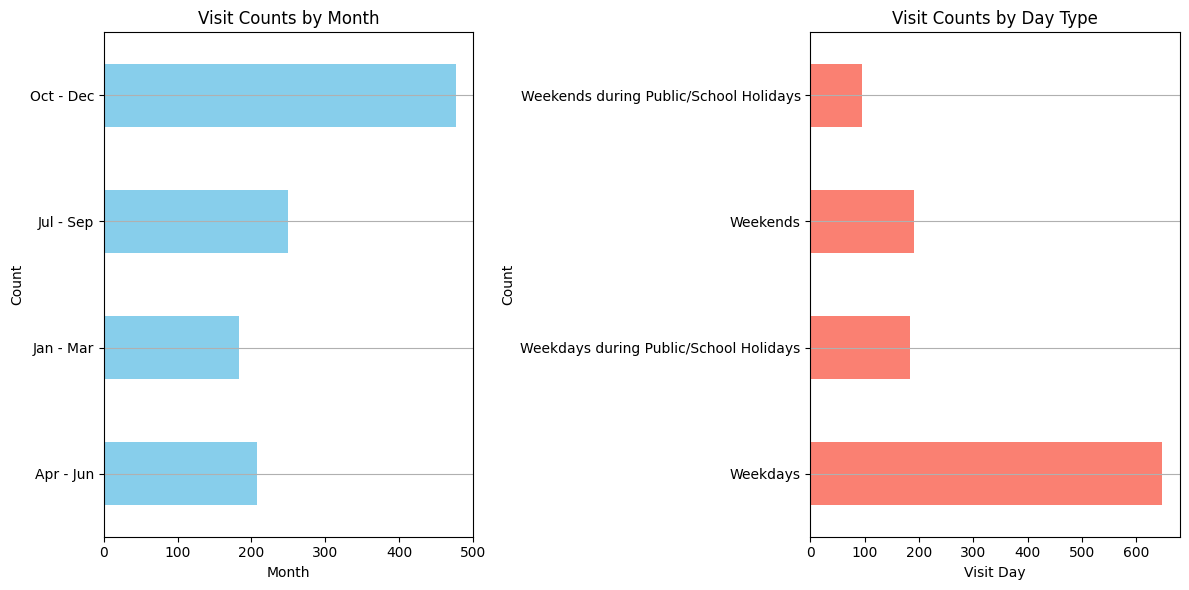

In [45]:
# plot traffic according to months and visit day
month_counts = most_popular_food_df['visit_month'].value_counts().sort_index()
day_counts = most_popular_food_df['visit_day'].value_counts().sort_index()

# plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
month_counts.plot(kind='barh', color='skyblue')
plt.title('Visit Counts by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.grid(axis='y')

plt.subplot(1, 2, 2)
day_counts.plot(kind='barh', color='salmon')
plt.title('Visit Counts by Day Type')
plt.xlabel('Visit Day')
plt.ylabel('Count')
plt.grid(axis='y')

plt.tight_layout()
plt.show()

In [46]:
X_spend = most_popular_food_df[feature_columns]
y_spend = most_popular_food_df['food_spend']

X_wait = most_popular_food_df[feature_columns]
y_wait = most_popular_food_df['food_wait_time']

# split training and test
X_spend_train, X_spend_test, y_spend_train, y_spend_test = train_test_split(X_spend, y_spend, test_size=0.2, random_state=3101)
X_wait_train, X_wait_test, y_wait_train, y_wait_test = train_test_split(X_wait, y_wait, test_size=0.2, random_state=3101)

# train decision tree
dt_regressor_spend = DecisionTreeRegressor(random_state=3101)
dt_regressor_spend.fit(X_spend_train, y_spend_train)

dt_regressor_wait = DecisionTreeRegressor(random_state=3101)
dt_regressor_wait.fit(X_wait_train, y_wait_train)

DecisionTreeRegressor(random_state=3101)

In [47]:
# predictions
y_spend_pred = dt_regressor_spend.predict(X_spend_test)
y_wait_pred = dt_regressor_wait.predict(X_wait_test)

# evaluate
mse_spend = mean_squared_error(y_spend_test, y_spend_pred)
r2_spend = r2_score(y_spend_test, y_spend_pred)

print(f'Food Spend: Mean Squared Error: {mse_spend}, R-squared: {r2_spend}')

mse_wait = mean_squared_error(y_wait_test, y_wait_pred)
r2_wait = r2_score(y_wait_test, y_wait_pred)

print(f'Food Wait Time: Mean Squared Error: {mse_wait}, R-squared: {r2_wait}')

Food Spend: Mean Squared Error: 66.80063664617693, R-squared: -0.004371552306895676
Food Wait Time: Mean Squared Error: 21.05682957048261, R-squared: -0.012121665187223574


The negative R-squared value indicate that the decision tree performs poorly.

# Stores

For stores, we have data from the surveys on the amount spent on merchandise.

In [48]:
stores_df

,store_name,visit_count,proportion,popularity_factor
0,[Hollywood] Universal Studios Store,2590,1.000000,2.000000
1,[Hollywood] Minion Mart,2260,0.872587,1.745174
2,[Hollywood] Hello Kitty Studio Store,486,0.187645,0.375290
3,[Hollywood] The Dark Room,169,0.065251,0.130502
4,[Hollywood] Candylicious,769,0.296911,0.593822
5,[New York] Big Bird's Emporium,322,0.124324,0.248649
6,[Sci-Fi City] Transformers Supply Vault,490,0.189189,0.378378
7,[The Lost World] The Dino-Store,819,0.316216,0.632432
8,[Far Far Away] Fairy Godmother's Potion Shop,1475,0.569498,1.138996


In [49]:
# most popular store
most_popular_store = stores_df[stores_df['proportion'] == 1]['store_name'][0]
most_popular_store = re.sub(r'\[.*?\]', '', most_popular_store).strip()
print(f"The most visited store is {most_popular_store}.")

The most visited store is Universal Studios Store.


In [50]:
# data preparation for most popular food outlet
selected_columns = ['visit_day', 'visit_month', 'merchandise_spend']

most_popular_store_df = survey_data[
    survey_data['which store(s) did you visit? (select all that apply)']
    .str.contains(most_popular_store, case=False, na=False)]
most_popular_store_df = most_popular_store_df[selected_columns]

# remove rows with NA values for merchandise_spend
most_popular_store_df = most_popular_store_df.dropna(subset=['merchandise_spend'])

# spend mapping
replacements_spend = {
    '< $10': 5,
    '$10 - $20': 15,
    '$20 - $30': 25,
    '> $30': 35
}
most_popular_store_df['merchandise_spend'] = most_popular_store_df['merchandise_spend'].replace(replacements_spend).astype(float)

# change to one-hot encoding
encoded_most_popular_store_df = pd.get_dummies(most_popular_store_df, columns=['visit_day', 'visit_month'], drop_first=True)

print(encoded_most_popular_store_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 739 entries, 8 to 5064
Data columns (total 7 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   merchandise_spend                                 739 non-null    float64
 1   visit_day_Weekdays during Public/School Holidays  739 non-null    bool   
 2   visit_day_Weekends                                739 non-null    bool   
 3   visit_day_Weekends during Public/School Holidays  739 non-null    bool   
 4   visit_month_Jan - Mar                             739 non-null    bool   
 5   visit_month_Jul - Sep                             739 non-null    bool   
 6   visit_month_Oct - Dec                             739 non-null    bool   
dtypes: bool(6), float64(1)
memory usage: 15.9 KB
None


/var/folders/pr/hvc7f3n57m539fg1hchqjr7h0000gn/T/ipykernel_41626/1091043796.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  most_popular_store_df['merchandise_spend'] = most_popular_store_df['merchandise_spend'].replace(replacements_spend).astype(float)


In [51]:
feature_columns = encoded_most_popular_store_df.iloc[:, 1:7]

In [52]:
X_merch_spend = encoded_most_popular_store_df[feature_columns]
y_merch_spend = encoded_most_popular_store_df['merchandise_spend']

# split training and test
X_merch_spend_train, X_merch_spend_test, y_merch_spend_train, y_merch_spend_test = train_test_split(X_merch_spend, y_merch_spend, test_size=0.2, random_state=3101)

# train decision tree
dt_regressor_merch_spend = DecisionTreeRegressor(random_state=3101)
dt_regressor_merch_spend.fit(X_merch_spend_train, y_merch_spend_train)

DecisionTreeRegressor(random_state=3101)

In [53]:
# predictions
y_merch_spend_pred = dt_regressor_merch_spend.predict(X_merch_spend_test)

# evaluate
mse_merch_spend = mean_squared_error(y_merch_spend_test, y_merch_spend_pred)
r2_merch_spend = r2_score(y_merch_spend_test, y_merch_spend_pred)

print(f'Merch Spend: Mean Squared Error: {mse_merch_spend}, R-squared: {r2_merch_spend}')


Merch Spend: Mean Squared Error: 104.26629314258473, R-squared: -0.010373776763040299


The negative R-squared value indicate that the decision tree performs poorly.